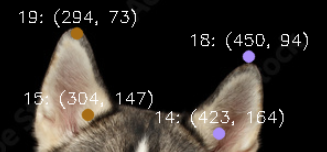

# Remove background

In [1]:
# Importing Required Modules 
from rembg import remove 
from PIL import Image 

# Store path of the image in the variable input_path 
input_path = 'warpPerspective_img.png' 

# Store path of the output image in the variable output_path 
output_path = 'warpPerspective_img_check_png.png' 

# Processing the image 
input = Image.open(input_path) 

# Removing the background from the given Image 
output = remove(input) 

#Saving the image in the given path 
output.save(output_path) 


In [2]:
# Store path of the image in the variable input_path 
input_path = 'warpPerspective_img.png' 

# Store path of the output image in the variable output_path 
output_path = 'warpPerspective_img_check_png.png' 

# Processing the image 
input = Image.open(input_path) 

In [3]:


# Removing the background from the given Image 
output = remove(input) 

#Saving the image in the given path 
output.save(output_path) 

# Paste PNG in another image

In [1]:
from PIL import Image
  
# Opening the primary image (used in background) 
img1 = Image.open("animal-tryon/input/istockphoto-509092254-612x612-removebg-preview.jpg") 
  
# Opening the secondary image (overlay image) 
img2 = Image.open('warpPerspective_img.png') 

# Pasting img2 image on top of img1  
# starting at coordinates (0, 0) 
img1.paste(img2, (0,0), mask = img2) 
  
# Displaying the image 
img1.show()

# Maintain aspect ratio according to width

In [3]:
import cv2

def resize_with_aspect_ratio(image_path, new_width=None, new_height=None):
    # Read the image
    img = cv2.imread(image_path)

    # Get the current height and width
    height, width = img.shape[:2]

    # If only width is specified
    if new_width is not None and new_height is None:
        # Calculate the aspect ratio and new height
        aspect_ratio = width / height
        new_height = int(new_width / aspect_ratio)

    # If only height is specified
    elif new_height is not None and new_width is None:
        # Calculate the aspect ratio and new width
        aspect_ratio = height / width
        new_width = int(new_height / aspect_ratio)

    # If both width and height are specified, ignore aspect ratio
    elif new_width is not None and new_height is not None:
        pass

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))

    # Display the original and resized images
    cv2.imshow("Original Image", img)
    cv2.imshow("Resized Image", resized_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# resize_with_aspect_ratio("animal-tryon/accessories/hat-removebg-preview.png", new_width=300)


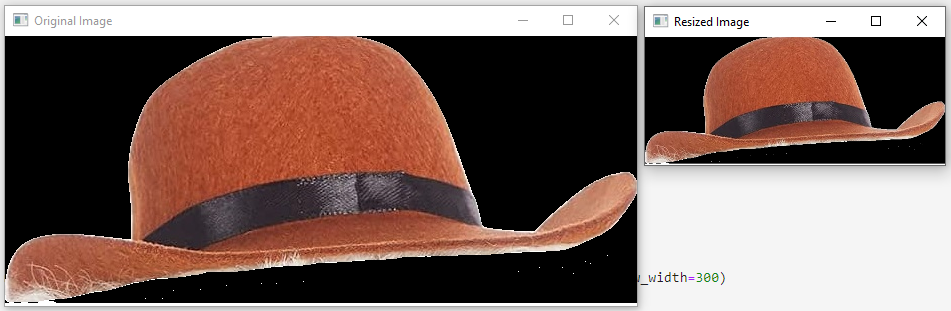

# Auto adjust and place accessories in the specific location

In [21]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [35]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import cvzone
from PIL import Image 

model_path = 'animal-tryon/best.pt'
keywords_file = "animal-tryon/keypoint_definitions.csv"
animal_img = 'animal-tryon/input/dog2.jpg'

accessories_img = 'animal-tryon/accessories/hat2.png'
result_png = 'png_result.png'


ann_meta_data = pd.read_csv(keywords_file)
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

model = YOLO(model_path)

BOX_IOU_THRESH = 0.55
BOX_CONF_THRESH=0.30
KPT_CONF_THRESH=0.68

inc = 15



image = cv2.imread(animal_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(animal_img, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

if not len(results.boxes.xyxy):
    image

# Get the predicted boxes, conf scores and keypoints.
pred_boxes = results.boxes.xyxy.numpy()
pred_box_conf = results.boxes.conf.numpy()
pred_kpts_xy = results.keypoints.xy.numpy()
pred_kpts_conf = results.keypoints.conf.numpy()

# Draw predicted bounding boxes, conf scores and keypoints on image.
for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
    kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
    filter_kpts = kpts[kpts_ids]
    filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
    # image = draw_boxes(image, boxes, score=score)
    # print('******** filter_kpts: ', filter_kpts)
    
    # filter_kpts = filter_kpts.astype("int").tolist()
    filter_kpts = [[int(x) for x in inner_list] for inner_list in filter_kpts]

    print('******** filter_kpts: ', filter_kpts)


    ################ check four points 

    # Points to check
    points_to_check = [14, 15, 19, 18]
    
    # Check if all points exist in the third item of any list
    all_points_exist = all(point in [sublist[2] for sublist in filter_kpts] for point in points_to_check)
    
    if all_points_exist:
        print("************ All points exist.")
        cap = cv2.imread(accessories_img, cv2.IMREAD_UNCHANGED)
        ani = cv2.imread(animal_img)
        
        
        
        cap_h,cap_w =  cap.shape[:2]
    
        head_coordinates = [item for item in filter_kpts if item[2] in points_to_check]
        head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
        print('head coordinates position--------------------', head_coordinates_position)
        print('length of head coordinates position--------------------', len(head_coordinates_position))
        
        head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
        print('head coordinates position--------------------', head_coordinates_position)

        
        pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
        pts2=np.float32(head_coordinates_position)
        print(f'---------- pts2 {pts2}')
        
        
        h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    
        print(f'---------- h {h}')
        
        
        height, width, channels = ani.shape
        im1Reg = cv2.warpPerspective(cap, h, (width, height))
        cv2.imwrite(result_png, im1Reg)
        
        # Opening the primary image (used in background) 
        img1 = Image.open(animal_img) 
          
        # Opening the secondary image (overlay image) 
        img2 = Image.open(result_png) 
        
        # Pasting img2 image on top of img1  
        # starting at coordinates (0, 0) 
        img1.paste(img2, (0,0), mask = img2) 
          
        # Displaying the image 
        img1.show()
    else:
        missing_points = [point for point in points_to_check if point not in [sublist[2] for sublist in filter_kpts]]
        print(f" ************The following points are missing: {missing_points}")
    #########################
    
    

# plt.imshow(image)
# plt.show()
    


image 1/1 D:\closet\tryon\animal-tryon\input\dog2.jpg: 640x480 1 dog, 589.0ms
Speed: 3.0ms preprocess, 589.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


******** filter_kpts:  [[258, 534, 0], [249, 477, 1], [249, 390, 2], [192, 533, 6], [182, 478, 7], [163, 394, 8], [242, 150, 14], [172, 154, 15], [208, 227, 16], [210, 258, 17], [251, 117, 18], [163, 124, 19]]
Both 14 and 15 exist.
************ All points exist.
head coordinates position-------------------- [[163, 124, 19], [251, 117, 18], [172, 154, 15], [242, 150, 14]]
length of head coordinates position-------------------- 4
head coordinates position-------------------- [[163, 139], [251, 132], [172, 169], [242, 165]]
---------- pts2 [[        163         139]
 [        251         132]
 [        172         169]
 [        242         165]]
---------- h [[    0.16028     0.25066         163]
 [  -0.033063      0.3485         139]
 [-0.00013367   0.0012045           1]]


# Work on only width 

In [5]:
def resize_with_aspect_ratio(image_path, new_width=None, new_height=None):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Get the current height and width
    height, width = img.shape[:2]

    # If only width is specified
    if new_width is not None and new_height is None:
        # Calculate the aspect ratio and new height
        aspect_ratio = width / height
        new_height = int(new_width / aspect_ratio)

    # If only height is specified
    elif new_height is not None and new_width is None:
        # Calculate the aspect ratio and new width
        aspect_ratio = height / width
        new_width = int(new_height / aspect_ratio)

    # If both width and height are specified, ignore aspect ratio
    elif new_width is not None and new_height is not None:
        pass

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img
    # print('cap_resized_acc_width saved =================')
    # cv2.imwrite('cap_resized_acc_width.png', resized_img)

    
    # Display the original and resized images
    # cv2.imshow("Original Image", img)
    # cv2.imshow("Resized Image", resized_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


# def draw_landmarks(image, landmarks):

#     radius = 5
#     # Check if image width is greater than 1000 px.
#     # To improve visualization.
#     if (image.shape[1] > 1000):
#         radius = 8

#     for idx, kpt_data in enumerate(landmarks):

#         loc_x, loc_y = kpt_data[:2].astype("int").tolist()
#         color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

#         cv2.circle(image,
#                    (loc_x, loc_y),
#                    radius,
#                    color=color_id[::-1],
#                    thickness=-1,
#                    lineType=cv2.LINE_AA)

#     return image



def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):
        # Check if kpt_data is a list or a NumPy array
        if isinstance(kpt_data, list):
            loc_x, loc_y = map(int, kpt_data[:2])
        elif isinstance(kpt_data, np.ndarray):
            loc_x, loc_y = map(int, kpt_data[:2])
        else:
            raise ValueError(f"Unsupported type for kpt_data: {type(kpt_data)}")

        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image


In [32]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import cvzone
from PIL import Image 

model_path = 'animal-tryon/best.pt'
keywords_file = "animal-tryon/keypoint_definitions.csv"
animal_img = 'animal-tryon/input/dog1.jpg'

accessories_img = 'animal-tryon/accessories/hat1.png'
result_png = 'png_result.png'


ann_meta_data = pd.read_csv(keywords_file)
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

model = YOLO(model_path)

BOX_IOU_THRESH = 0.55
BOX_CONF_THRESH=0.30
KPT_CONF_THRESH=0.68

inc = 15



image = cv2.imread(animal_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(animal_img, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

if not len(results.boxes.xyxy):
    image

# Get the predicted boxes, conf scores and keypoints.
pred_boxes = results.boxes.xyxy.numpy()
pred_box_conf = results.boxes.conf.numpy()
pred_kpts_xy = results.keypoints.xy.numpy()
pred_kpts_conf = results.keypoints.conf.numpy()

# Draw predicted bounding boxes, conf scores and keypoints on image.
for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
    kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
    filter_kpts = kpts[kpts_ids]
    filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
    # image = draw_boxes(image, boxes, score=score)
    # print('******** filter_kpts: ', filter_kpts)
    
    # filter_kpts = filter_kpts.astype("int").tolist()
    filter_kpts = [[int(x) for x in inner_list] for inner_list in filter_kpts]

    print('******** filter_kpts: ', filter_kpts)

    ################# Check if 14 and 15 exist in the third item of each list
    point_14_exists = any(14 == sublist[2] for sublist in filter_kpts)
    point_15_exists = any(15 == sublist[2] for sublist in filter_kpts)
    if point_14_exists and point_15_exists:
        # Find the keypoints with IDs 14 and 15
        point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)
        
        print("********************* Both 14 and 15 exist.")
        # Calculate the width between points 14 and 15
        width_14_15 = np.sqrt((point_14[0] - point_15[0])**2 + (point_14[1] - point_15[1])**2)
        resized_accessories_img  = resize_with_aspect_ratio(accessories_img, int(width_14_15))

        
        print(f"********************* The width between points 14 and 15 is: {width_14_15}")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

        print('%%%%%%%%%%% shape of png', resized_accessories_img.shape)
        
        ##### put png in background image

        # y_axis = abs(point_15[1] - resized_accessories_img.shape[1])
        # y_axis = abs(resized_accessories_img.shape[1]  - point_15[1] )
        # y_axis = abs( point_15[1] - int(resized_accessories_img.shape[1] * 1.2))

        percentage_to_subtract = 38 
        offset_y = int(percentage_to_subtract / 100 * resized_accessories_img.shape[1])
        
        print('aaaaaaaaaaaaaaaa', y_axis)
        image = cvzone.overlayPNG(image, resized_accessories_img, (point_15[0], point_15[1] - offset_y ))
        image = draw_landmarks(image, filter_kpts)

        
        # cv2.imshow("Resized Accessories", resized_accessories_img)
        cv2.imshow("Original Image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("********************* Neither 14 nor 15 exists.")
    ################ 

   
    
    # image = draw_landmarks(image, filter_kpts)
    
    ###### get head area **** start ****
    
    # head_coordinates = [item for item in filter_kpts if item[2] in [18, 14, 15, 19]]
    # head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
    # print('head coordinates position--------------------', head_coordinates_position)
    # print('length of head coordinates position--------------------', len(head_coordinates_position))
    
    # head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
    # print('head coordinates position--------------------', head_coordinates_position)
    
    # ###### get head area **** end ****
    
    # cap = cv2.imread(accessories_img, cv2.IMREAD_UNCHANGED)
    # ani = cv2.imread(animal_img)
    
    
    
    # cap_h,cap_w =  cap.shape[:2]


    # pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
    # pts2=np.float32(head_coordinates_position)
    # print(f'---------- pts2 {pts2}')
    
    
    # h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)

    # print(f'---------- h {h}')
    
    
    # height, width, channels = ani.shape
    # im1Reg = cv2.warpPerspective(cap, h, (width, height))
    # cv2.imwrite(result_png, im1Reg)
    
    # # Opening the primary image (used in background) 
    # img1 = Image.open(animal_img) 
      
    # # Opening the secondary image (overlay image) 
    # img2 = Image.open(result_png) 
    
    # # Pasting img2 image on top of img1  
    # # starting at coordinates (0, 0) 
    # img1.paste(img2, (0,0), mask = img2) 
      
    # # Displaying the image 
    # img1.show()

# plt.imshow(image)
# plt.show()
    


image 1/1 D:\closet\tryon\animal-tryon\input\dog1.jpg: 640x448 1 dog, 681.0ms
Speed: 3.0ms preprocess, 681.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


******** filter_kpts:  [[432, 906, 0], [402, 794, 1], [391, 613, 2], [202, 895, 6], [224, 785, 7], [227, 606, 8], [423, 164, 14], [304, 147, 15], [343, 322, 16], [341, 378, 17], [450, 94, 18], [294, 73, 19]]
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 120.20815280171308
%%%%%%%%%%% shape of png (51, 120, 4)
aaaaaaaaaaaaaaaa 143


## check two and four points togather 

In [8]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import cvzone
from PIL import Image 

model_path = 'animal-tryon/best.pt'
keywords_file = "animal-tryon/keypoint_definitions.csv"
animal_img = 'animal-tryon/input/GettyImages-997016774-800x532.jpg'

accessories_img = 'animal-tryon/accessories/hat1.png'
result_png = 'png_result.png'


ann_meta_data = pd.read_csv(keywords_file)
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

model = YOLO(model_path)

BOX_IOU_THRESH = 0.55
BOX_CONF_THRESH=0.30
KPT_CONF_THRESH=0.68

inc = 15



image = cv2.imread(animal_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(animal_img, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

if not len(results.boxes.xyxy):
    image

# Get the predicted boxes, conf scores and keypoints.
pred_boxes = results.boxes.xyxy.numpy()
pred_box_conf = results.boxes.conf.numpy()
pred_kpts_xy = results.keypoints.xy.numpy()
pred_kpts_conf = results.keypoints.conf.numpy()

# Draw predicted bounding boxes, conf scores and keypoints on image.
for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
    kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
    filter_kpts = kpts[kpts_ids]
    filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
    # image = draw_boxes(image, boxes, score=score)
    # print('******** filter_kpts: ', filter_kpts)
    
    # filter_kpts = filter_kpts.astype("int").tolist()
    filter_kpts = [[int(x) for x in inner_list] for inner_list in filter_kpts]

    print('******** filter_kpts: ', filter_kpts)
    
    


    
    ################ check four points 

    # Points to check
    points_to_check = [14, 15, 19, 18]

    ################# Check two points (if 14 and 15 exist in the third item of each list)
    
    point_14_exists = any(14 == sublist[2] for sublist in filter_kpts)
    point_15_exists = any(15 == sublist[2] for sublist in filter_kpts)
    
    # Check if all points exist in the third item of any list
    all_points_exist = all(point in [sublist[2] for sublist in filter_kpts] for point in points_to_check)
    
    if all_points_exist:
        print("************ All points exist.")
        cap = cv2.imread(accessories_img, cv2.IMREAD_UNCHANGED)
        ani = cv2.imread(animal_img)
        
        
        
        cap_h,cap_w =  cap.shape[:2]
    
        head_coordinates = [item for item in filter_kpts if item[2] in points_to_check]
        head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
        print('head coordinates position--------------------', head_coordinates_position)
        print('length of head coordinates position--------------------', len(head_coordinates_position))
        
        head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
        print('head coordinates position--------------------', head_coordinates_position)

        
        pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
        pts2=np.float32(head_coordinates_position)
        print(f'---------- pts2 {pts2}')
        
        
        h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    
        print(f'---------- h {h}')
        
        
        height, width, channels = ani.shape
        im1Reg = cv2.warpPerspective(cap, h, (width, height))
        cv2.imwrite(result_png, im1Reg)
        
        # Opening the primary image (used in background) 
        img1 = Image.open(animal_img) 
          
        # Opening the secondary image (overlay image) 
        img2 = Image.open(result_png) 
        
        # Pasting img2 image on top of img1  
        # starting at coordinates (0, 0) 
        img1.paste(img2, (0,0), mask = img2) 
          
        # Displaying the image 
        img1.show()
        
    
    elif point_14_exists and point_15_exists:

        
        # get value of 14 and 15
        point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)
        
        print("********************* Both 14 and 15 exist.")
        # Calculate the width between points 14 and 15
        width_14_15 = np.sqrt((point_14[0] - point_15[0])**2 + (point_14[1] - point_15[1])**2)
        resized_accessories_img  = resize_with_aspect_ratio(accessories_img, int(width_14_15))

        
        print(f"********************* The width between points 14 and 15 is: {width_14_15}")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

        print('%%%%%%%%%%% shape of png', resized_accessories_img.shape)
        
        ##### put png in background image

        # y_axis = abs(point_15[1] - resized_accessories_img.shape[1])
        # y_axis = abs(resized_accessories_img.shape[1]  - point_15[1] )
        # y_axis = abs( point_15[1] - int(resized_accessories_img.shape[1] * 1.2))

        percentage_to_subtract = 38 
        offset_y = int(percentage_to_subtract / 100 * resized_accessories_img.shape[1])
        
        image = cvzone.overlayPNG(image, resized_accessories_img, (point_15[0], point_15[1] - offset_y ))
        # image = draw_landmarks(image, filter_kpts)

        
        # cv2.imshow("Resized Accessories", resized_accessories_img)
        cv2.imshow("Original Image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    ################# Check two points code end
    else:
        missing_points = [point for point in points_to_check if point not in [sublist[2] for sublist in filter_kpts]]
        print(f" ************The following points are missing: {missing_points}")
        # print("********************* Neither 14 nor 15 exists.")
    ################ 


image 1/1 D:\closet\tryon\animal-tryon\input\GettyImages-997016774-800x532.jpg: 448x640 1 dog, 487.0ms
Speed: 3.0ms preprocess, 487.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


******** filter_kpts:  [[427, 150, 14], [291, 163, 15], [375, 303, 16], [277, 118, 19]]
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 136.61991070118586
%%%%%%%%%%% shape of png (58, 136, 4)


## Concise code (four and two points )

In [8]:
def resize_with_aspect_ratio(image_path, new_width=None, new_height=None):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Get the current height and width
    height, width = img.shape[:2]

    # If only width is specified
    if new_width is not None and new_height is None:
        # Calculate the aspect ratio and new height
        aspect_ratio = width / height
        new_height = int(new_width / aspect_ratio)

    # If only height is specified
    elif new_height is not None and new_width is None:
        # Calculate the aspect ratio and new width
        aspect_ratio = height / width
        new_width = int(new_height / aspect_ratio)

    # If both width and height are specified, ignore aspect ratio
    elif new_width is not None and new_height is not None:
        pass

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img




def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):
        # Check if kpt_data is a list or a NumPy array
        if isinstance(kpt_data, list):
            loc_x, loc_y = map(int, kpt_data[:2])
        elif isinstance(kpt_data, np.ndarray):
            loc_x, loc_y = map(int, kpt_data[:2])
        else:
            raise ValueError(f"Unsupported type for kpt_data: {type(kpt_data)}")

        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)
         # Draw keypoint number
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        # text = str(int(kpt_data[-1]))
        text = f"{int(kpt_data[-1])}: ({loc_x}, {loc_y})"
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = loc_x - text_size[0] // 2
        text_y = loc_y - radius - 5
        print('************* text:', text)
        cv2.putText(image, text, (text_x, text_y), font, font_scale, color=(255, 255, 255), thickness=font_thickness)

    return image


## modifying wear_cap

In [2]:
def wear_cap(accessories_img_path,animal_image,  filter_kpts):
    ############################### cap working ############################### 

    ################# Check two points (if 14 and 15 exist in the third item of each list)
    
    point_14_exists = any(14 == sublist[2] for sublist in filter_kpts)
    point_15_exists = any(15 == sublist[2] for sublist in filter_kpts)


    

    ################ check four points 

    # Points to check
    points_to_check = [14, 15, 19, 18]
    
    # Check if all points exist in the third item of any list
    all_points_exist = all(point in [sublist[2] for sublist in filter_kpts] for point in points_to_check)
    print(f'----------****** four points exits ******----------{all_points_exist}', )
    if all_points_exist:
        print("************ All points exist.")
        

        ## *********** check if 19 > 15 and 18 > 14 (condition to correct image flip )
        # get value of 19 and 15
        point_19 = next(sublist for sublist in filter_kpts if sublist[2] == 19)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)

        if point_19[1] > point_15[1]:
            
            
    
    
            # get value of 18 and 14
            point_18 = next(sublist for sublist in filter_kpts if sublist[2] == 18)
            point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)

            # Calculate the width between points 14 and 15
            width_19_15 = np.sqrt((point_19[0] - point_15[0])**2 + (point_19[1] - point_15[1])**2)
            
            # Calculate the width between points 14 and 15
            width_18_14 = np.sqrt((point_18[0] - point_14[0])**2 + (point_18[1] - point_14[1])**2)
            
            print('>>>>>>>>>>>>>>>> length of 18 and 14: ', width_18_14)
            print('>>>>>>>>>>>>>>>> length of 19 and 15: ', width_19_15)
            print('\n19, 15, 18, 14 origranl', [point_19, point_15, point_18, point_14])
    
            point_19[1] = int(point_19[1] - 2 * width_19_15)
            point_18[1] = int(point_18[1] - 2 * width_18_14)
            
            print('19, 15, 18, 14 decreamented\n', [point_19, point_15, point_18, point_14])

            filter_kpts[-1] = point_19 
            filter_kpts[-2] = point_18
        else:
            pass
            
        cap = cv2.imread(accessories_img_path, cv2.IMREAD_UNCHANGED)
        cap_h,cap_w =  cap.shape[:2]

        print('******** new filter_kpts: ', filter_kpts)
        
        
        head_coordinates = [item for item in filter_kpts if item[2] in points_to_check]
        head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
        print('-------------------- head coordinates position with keypoint numbers: ', head_coordinates_position)
        print('-------------------- length of head coordinates position: ', len(head_coordinates_position))
        
        head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
        print('-------------------- head coordinates position without keypoint numbers: ', head_coordinates_position)
        
        pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
        pts2=np.float32(head_coordinates_position)
        
        h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    
        height, width, channels = animal_image.shape
        im1Reg = cv2.warpPerspective(cap, h, (width, height))
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB) 
        animal_image_result = cvzone.overlayPNG(animal_image, im1Reg, (0, 0))
        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    
    elif point_14_exists and point_15_exists:

        
        # get value of 14 and 15
        point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)
        
        print("********************* Both 14 and 15 exist.")
        

        
        # Calculate the width between points 14 and 15
        width_14_15 = np.sqrt((point_14[0] - point_15[0])**2 + (point_14[1] - point_15[1])**2)
        resized_accessories_img  = resize_with_aspect_ratio(accessories_img_path, int(width_14_15))

        
        print(f"********************* The width between points 14 and 15 is: {width_14_15}")
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_RGB2BGR) 

        print('%%%%%%%%%%% shape of png', resized_accessories_img.shape)
        

        percentage_to_subtract = 38 
        offset_y = int(percentage_to_subtract / 100 * resized_accessories_img.shape[1])
        
        animal_image_result = cvzone.overlayPNG(animal_image, resized_accessories_img, (point_15[0], point_15[1] - offset_y ))

        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    ################# Check two points code end
    else:
        missing_points = [point for point in points_to_check if point not in [sublist[2] for sublist in filter_kpts]]
        print(f" ************The following points are missing: {missing_points}")
    ############################### cap working end ###############################

## Working on image

In [1]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import cvzone
from PIL import Image 

model_path = 'animal-tryon/best.pt'
keywords_file = "animal-tryon/keypoint_definitions.csv"
animal_img = 'animal-tryon/input/dog1.jpg'
# animal_img = 'animal-tryon/images_data/frame_56.png'

accessories_img = 'animal-tryon/accessories/hat1.png'
result_png = 'png_result.png'


ann_meta_data = pd.read_csv(keywords_file)
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

model = YOLO(model_path)

BOX_IOU_THRESH = 0.55
BOX_CONF_THRESH=0.30
KPT_CONF_THRESH=0.68

inc = 15



animal_image = cv2.imread(animal_img)
animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB)

cap = cv2.imread(accessories_img, cv2.IMREAD_UNCHANGED)

results = model.predict(animal_img, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

if not len(results.boxes.xyxy):
    animal_image

# Get the predicted boxes, conf scores and keypoints.
pred_boxes = results.boxes.xyxy.numpy()
pred_box_conf = results.boxes.conf.numpy()
pred_kpts_xy = results.keypoints.xy.numpy()
pred_kpts_conf = results.keypoints.conf.numpy()


def resize_with_aspect_ratio(img, new_width=None, new_height=None):
    # Get the current height and width
    height, width = img.shape[:2]

    # If only width is specified
    if new_width is not None and new_height is None:
        # Calculate the aspect ratio and new height
        aspect_ratio = width / height
        new_height = int(new_width / aspect_ratio)

    # If only height is specified
    elif new_height is not None and new_width is None:
        # Calculate the aspect ratio and new width
        aspect_ratio = height / width
        new_width = int(new_height / aspect_ratio)

    # If both width and height are specified, ignore aspect ratio
    elif new_width is not None and new_height is not None:
        pass

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img

############################### cap working ############################### 
def wear_cap(cap,animal_image,  filter_kpts):
    

    ################# Check two points (if 14 and 15 exist in the third item of each list)
    
    point_14_exists = any(14 == sublist[2] for sublist in filter_kpts)
    point_15_exists = any(15 == sublist[2] for sublist in filter_kpts)


    

    ################ check four points 

    # Points to check
    points_to_check = [14, 15, 19, 18]
    
    # Check if all points exist in the third item of any list
    all_points_exist = all(point in [sublist[2] for sublist in filter_kpts] for point in points_to_check)
    print(f'----------****** four points exits ******----------{all_points_exist}', )
    if all_points_exist:
        print("************ All points exist.")
        

        ## *********** check if 19 > 15 and 18 > 14 (condition to correct image flip )
        # get value of 19 and 15
        point_19 = next(sublist for sublist in filter_kpts if sublist[2] == 19)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)

        if point_19[1] > point_15[1]:
            
            
    
    
            # get value of 18 and 14
            point_18 = next(sublist for sublist in filter_kpts if sublist[2] == 18)
            point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)

            # Calculate the width between points 14 and 15
            width_19_15 = np.sqrt((point_19[0] - point_15[0])**2 + (point_19[1] - point_15[1])**2)
            
            # Calculate the width between points 14 and 15
            width_18_14 = np.sqrt((point_18[0] - point_14[0])**2 + (point_18[1] - point_14[1])**2)
            
            print('>>>>>>>>>>>>>>>> length of 18 and 14: ', width_18_14)
            print('>>>>>>>>>>>>>>>> length of 19 and 15: ', width_19_15)
            print('\n19, 15, 18, 14 origranl', [point_19, point_15, point_18, point_14])
    
            point_19[1] = int(point_19[1] - 2 * width_19_15)
            point_18[1] = int(point_18[1] - 2 * width_18_14)
            
            print('19, 15, 18, 14 decreamented\n', [point_19, point_15, point_18, point_14])

            filter_kpts[-1] = point_19 
            filter_kpts[-2] = point_18
        else:
            pass
            
        # cap = cv2.imread(accessories_img_path, cv2.IMREAD_UNCHANGED)
        cap_h,cap_w =  cap.shape[:2]

        print('******** new filter_kpts: ', filter_kpts)
        
        
        head_coordinates = [item for item in filter_kpts if item[2] in points_to_check]
        head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
        print('-------------------- head coordinates position with keypoint numbers: ', head_coordinates_position)
        print('-------------------- length of head coordinates position: ', len(head_coordinates_position))
        
        head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
        print('-------------------- head coordinates position without keypoint numbers: ', head_coordinates_position)
        
        pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
        pts2=np.float32(head_coordinates_position)
        
        h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    
        height, width, channels = animal_image.shape
        im1Reg = cv2.warpPerspective(cap, h, (width, height))
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB) 
        animal_image_result = cvzone.overlayPNG(animal_image, im1Reg, (0, 0))
        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    
    elif point_14_exists and point_15_exists:

        
        # get value of 14 and 15
        point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)
        
        print("********************* Both 14 and 15 exist.")
        

        
        # Calculate the width between points 14 and 15
        width_14_15 = np.sqrt((point_14[0] - point_15[0])**2 + (point_14[1] - point_15[1])**2)
        resized_accessories_img  = resize_with_aspect_ratio(cap, int(width_14_15))

        
        print(f"********************* The width between points 14 and 15 is: {width_14_15}")
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_RGB2BGR) 

        print('%%%%%%%%%%% shape of png', resized_accessories_img.shape)
        

        percentage_to_subtract = 38 
        offset_y = int(percentage_to_subtract / 100 * resized_accessories_img.shape[1])
        
        animal_image_result = cvzone.overlayPNG(animal_image, resized_accessories_img, (point_15[0], point_15[1] - offset_y ))

        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    ################# Check two points code end
    else:
        missing_points = [point for point in points_to_check if point not in [sublist[2] for sublist in filter_kpts]]
        print(f" ************The following points are missing: {missing_points}")
############################### cap working end ###############################


def draw_landmarks(image, landmarks):
    radius = 5

    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if image.shape[1] > 1000:
        radius = 8

    for idx, kpt_data in enumerate(landmarks):
        loc_x, loc_y = np.array(kpt_data[:2], dtype=int).tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

      # Draw keypoint number
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    # text = str(int(kpt_data[-1]))
    text = f"{int(kpt_data[-1])}: ({loc_x}, {loc_y})"
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = loc_x - text_size[0] // 2
    text_y = loc_y - radius - 5
    print('************* text:', text)
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color=(255, 255, 255), thickness=font_thickness)

    return image




# Draw predicted bounding boxes, conf scores and keypoints on image.
for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
    kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
    filter_kpts = kpts[kpts_ids]
    filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
    
    # filter_kpts = filter_kpts.astype("int").tolist()
    filter_kpts = [[int(x) for x in inner_list] for inner_list in filter_kpts]
    print('******** old filter_kpts: ', filter_kpts)
    # animal_image = draw_landmarks(animal_image, filter_kpts)
    cap_wear_result = wear_cap(cap, animal_image, filter_kpts)
    # Check if the resulting image has valid dimensions
    if cap_wear_result is not None and cap_wear_result.shape[0] > 0 and cap_wear_result.shape[1] > 0:
        cv2.imshow("cap_wear_result", cap_wear_result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("Error: Invalid dimensions for the resulting image.")

        # print("********************* Neither 14 nor 15 exists.")
    ################ 


image 1/1 D:\closet\tryon\animal-tryon\input\dog1.jpg: 640x448 1 dog, 553.7ms
Speed: 4.0ms preprocess, 553.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)
******** old filter_kpts:  [[432, 906, 0], [402, 794, 1], [391, 613, 2], [202, 895, 6], [224, 785, 7], [227, 606, 8], [423, 164, 14], [304, 147, 15], [343, 322, 16], [341, 378, 17], [450, 94, 18], [294, 73, 19]]
----------****** four points exits ******----------True
************ All points exist.
******** new filter_kpts:  [[432, 906, 0], [402, 794, 1], [391, 613, 2], [202, 895, 6], [224, 785, 7], [227, 606, 8], [423, 164, 14], [304, 147, 15], [343, 322, 16], [341, 378, 17], [450, 94, 18], [294, 73, 19]]
-------------------- head coordinates position with keypoint numbers:  [[294, 73, 19], [450, 94, 18], [304, 147, 15], [423, 164, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[294, 88], [450, 109], [304, 162], [423, 1

## Working on videos

In [25]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import cvzone
from PIL import Image 

model_path = 'animal-tryon/best.pt'
keywords_file = "animal-tryon/keypoint_definitions.csv"

accessories_img = 'animal-tryon/accessories/hat1.png'
result_png = 'png_result.png'

ann_meta_data = pd.read_csv(keywords_file)
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

model = YOLO(model_path)

BOX_IOU_THRESH = 0.55
BOX_CONF_THRESH=0.30
KPT_CONF_THRESH=0.68

inc = 15

def wear_cap(accessories_img_path,animal_image,  filter_kpts):
    ############################### cap working ############################### 

    ################# Check two points (if 14 and 15 exist in the third item of each list)
    
    point_14_exists = any(14 == sublist[2] for sublist in filter_kpts)
    point_15_exists = any(15 == sublist[2] for sublist in filter_kpts)


    

    ################ check four points 

    # Points to check
    points_to_check = [14, 15, 19, 18]
    
    # Check if all points exist in the third item of any list
    all_points_exist = all(point in [sublist[2] for sublist in filter_kpts] for point in points_to_check)
    print(f'----------****** four points exits ******----------{all_points_exist}', )
    if all_points_exist:
        print("************ All points exist.")
        

        ## *********** check if 19 > 15 and 18 > 14 (condition to correct image flip )
        # get value of 19 and 15
        point_19 = next(sublist for sublist in filter_kpts if sublist[2] == 19)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)

        if point_19[1] > point_15[1]:
            
            
    
    
            # get value of 18 and 14
            point_18 = next(sublist for sublist in filter_kpts if sublist[2] == 18)
            point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)

            # Calculate the width between points 14 and 15
            width_19_15 = np.sqrt((point_19[0] - point_15[0])**2 + (point_19[1] - point_15[1])**2)
            
            # Calculate the width between points 14 and 15
            width_18_14 = np.sqrt((point_18[0] - point_14[0])**2 + (point_18[1] - point_14[1])**2)
            
            print('>>>>>>>>>>>>>>>> length of 18 and 14: ', width_18_14)
            print('>>>>>>>>>>>>>>>> length of 19 and 15: ', width_19_15)
            print('\n19, 15, 18, 14 origranl', [point_19, point_15, point_18, point_14])
    
            point_19[1] = int(point_19[1] - 2 * width_19_15)
            point_18[1] = int(point_18[1] - 2 * width_18_14)
            
            print('19, 15, 18, 14 decreamented\n', [point_19, point_15, point_18, point_14])

            filter_kpts[-1] = point_19 
            filter_kpts[-2] = point_18
        else:
            pass
            
        cap = cv2.imread(accessories_img_path, cv2.IMREAD_UNCHANGED)
        cap_h,cap_w =  cap.shape[:2]

        print('******** new filter_kpts: ', filter_kpts)
        
        
        head_coordinates = [item for item in filter_kpts if item[2] in points_to_check]
        head_coordinates_position = sorted(head_coordinates, key=lambda x: x[2], reverse=True)
        print('-------------------- head coordinates position with keypoint numbers: ', head_coordinates_position)
        print('-------------------- length of head coordinates position: ', len(head_coordinates_position))
        
        head_coordinates_position = [[item[0], item[1] + inc] for item in head_coordinates_position]
        print('-------------------- head coordinates position without keypoint numbers: ', head_coordinates_position)
        
        pts1=np.float32([[0,0],[cap_w,0],[0,cap_h],[cap_w,cap_h]])
        pts2=np.float32(head_coordinates_position)
        
        h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)
    
        height, width, channels = animal_image.shape
        im1Reg = cv2.warpPerspective(cap, h, (width, height))
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB) 
        animal_image_result = cvzone.overlayPNG(animal_image, im1Reg, (0, 0))
        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    
    elif point_14_exists and point_15_exists:

        
        # get value of 14 and 15
        point_14 = next(sublist for sublist in filter_kpts if sublist[2] == 14)
        point_15 = next(sublist for sublist in filter_kpts if sublist[2] == 15)
        
        print("********************* Both 14 and 15 exist.")
        

        
        # Calculate the width between points 14 and 15
        width_14_15 = np.sqrt((point_14[0] - point_15[0])**2 + (point_14[1] - point_15[1])**2)
        resized_accessories_img  = resize_with_aspect_ratio(accessories_img_path, int(width_14_15))

        
        print(f"********************* The width between points 14 and 15 is: {width_14_15}")
        animal_image = cv2.cvtColor(animal_image, cv2.COLOR_RGB2BGR) 

        print('%%%%%%%%%%% shape of png', resized_accessories_img.shape)
        

        percentage_to_subtract = 38 
        offset_y = int(percentage_to_subtract / 100 * resized_accessories_img.shape[1])
        
        animal_image_result = cvzone.overlayPNG(animal_image, resized_accessories_img, (point_15[0], point_15[1] - offset_y ))

        
        # cv2.imshow("Original Image", animal_image_result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return animal_image_result
    ################# Check two points code end
    else:
        missing_points = [point for point in points_to_check if point not in [sublist[2] for sublist in filter_kpts]]
        print(f" ************The following points are missing: {missing_points}")
    ############################### cap working end ###############################


# Open the video file
video_path = 'animal-tryon/input/dog_video2.mp4'
cap = cv2.VideoCapture(video_path)

# # Get the frames per second (fps) of the video
# fps = cap.get(cv2.CAP_PROP_FPS)

# # We need to set resolutions. 
# # so, convert them from float to integer. 
# frame_width = int(cap.get(3)) 
# frame_height = int(cap.get(4)) 
   
# size = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
# result = cv2.VideoWriter('filename.avi',  
#                          cv2.VideoWriter_fourcc(*'MJPG'), 
#                          10, size) 


# get FPS of input video 
fps = cap.get(cv2.CAP_PROP_FPS) 

# define output video and it's FPS 
output_file = 'output2.mp4'
output_fps = fps * 2
  
# define VideoWriter object 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_file, fourcc, output_fps, 
                      (int(cap.get(3)), int(cap.get(4)))) 

counter  = 1
while cap.isOpened():
    ret, animal_image = cap.read()

    if not ret:
        break
    # animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB)
    
    # results = model.predict(animal_image, conf=BOX_CONF_THRESH, ioQu=BOX_IOU_THRESH)[0].cpu()
    results = model.predict(animal_image, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        animal_image
    
    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()
    
    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        
        # filter_kpts = filter_kpts.astype("int").tolist()
        filter_kpts = [[int(x) for x in inner_list] for inner_list in filter_kpts]
        print('******** filter_kpts: ', filter_kpts)

    animal_image = cv2.cvtColor(animal_image, cv2.COLOR_BGR2RGB)
    # animal_image = draw_landmarks(animal_image, filter_kpts)
    cap_wear_result = wear_cap(accessories_img, animal_image, filter_kpts)
    
    # Write the frame to the output video
    out.write(cap_wear_result) 
    
    # Show the frame
    # cv2.imshow("Original Image", cap_wear_result)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Wait to achieve the desired frame rate (30fps)
    cv2.waitKey(int(1000 / fps))
    print(f'*********************** {counter} frames done ***********************')
    counter+=1


# Release the video capture object and close all windows
out.release()
cap.release()
cv2.destroyAllWindows()


0: 640x384 1 dog, 563.0ms
Speed: 4.0ms preprocess, 563.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[602, 562, 14], [184, 472, 15], [313, 920, 16], [298, 1022, 17], [670, 746, 18], [61, 623, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  196.16319736382766
>>>>>>>>>>>>>>>> length of 19 and 15:  194.7562579225633

19, 15, 18, 14 origranl [[61, 623, 19], [184, 472, 15], [670, 746, 18], [602, 562, 14]]
19, 15, 18, 14 decreamented
 [[61, 233, 19], [184, 472, 15], [670, 353, 18], [602, 562, 14]]
******** new filter_kpts:  [[602, 562, 14], [184, 472, 15], [313, 920, 16], [298, 1022, 17], [670, 353, 18], [61, 233, 19]]
-------------------- head coordinates position with keypoint numbers:  [[61, 233, 19], [670, 353, 18], [184, 472, 15], [602, 562, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[61, 248], [670, 368], [184, 487], [602, 577]]
*********************** 1 frames done ****************

0: 640x384 1 dog, 420.0ms
Speed: 2.0ms preprocess, 420.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[590, 549, 14], [176, 467, 15], [310, 910, 16], [296, 1009, 17], [669, 735, 18], [50, 620, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  202.08166665979377
>>>>>>>>>>>>>>>> length of 19 and 15:  198.20443990990717

19, 15, 18, 14 origranl [[50, 620, 19], [176, 467, 15], [669, 735, 18], [590, 549, 14]]
19, 15, 18, 14 decreamented
 [[50, 223, 19], [176, 467, 15], [669, 330, 18], [590, 549, 14]]
******** new filter_kpts:  [[590, 549, 14], [176, 467, 15], [310, 910, 16], [296, 1009, 17], [669, 330, 18], [50, 223, 19]]
-------------------- head coordinates position with keypoint numbers:  [[50, 223, 19], [669, 330, 18], [176, 467, 15], [590, 549, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[50, 238], [669, 345], [176, 482], [590, 564]]
*********************** 2 frames done ***************

0: 640x384 1 dog, 404.0ms
Speed: 3.0ms preprocess, 404.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[583, 541, 14], [163, 461, 15], [307, 913, 16], [293, 1013, 17], [662, 744, 18], [37, 627, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  217.83020910791964
>>>>>>>>>>>>>>>> length of 19 and 15:  208.4034548657963

19, 15, 18, 14 origranl [[37, 627, 19], [163, 461, 15], [662, 744, 18], [583, 541, 14]]
19, 15, 18, 14 decreamented
 [[37, 210, 19], [163, 461, 15], [662, 308, 18], [583, 541, 14]]
******** new filter_kpts:  [[583, 541, 14], [163, 461, 15], [307, 913, 16], [293, 1013, 17], [662, 308, 18], [37, 210, 19]]
-------------------- head coordinates position with keypoint numbers:  [[37, 210, 19], [662, 308, 18], [163, 461, 15], [583, 541, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[37, 225], [662, 323], [163, 476], [583, 556]]
*********************** 3 frames done ****************

0: 640x384 1 dog, 642.0ms
Speed: 3.0ms preprocess, 642.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[583, 541, 14], [163, 460, 15], [303, 911, 16], [291, 1011, 17], [665, 735, 18], [35, 619, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  210.61813787041228
>>>>>>>>>>>>>>>> length of 19 and 15:  204.12006270820123

19, 15, 18, 14 origranl [[35, 619, 19], [163, 460, 15], [665, 735, 18], [583, 541, 14]]
19, 15, 18, 14 decreamented
 [[35, 210, 19], [163, 460, 15], [665, 313, 18], [583, 541, 14]]
******** new filter_kpts:  [[583, 541, 14], [163, 460, 15], [303, 911, 16], [291, 1011, 17], [665, 313, 18], [35, 210, 19]]
-------------------- head coordinates position with keypoint numbers:  [[35, 210, 19], [665, 313, 18], [163, 460, 15], [583, 541, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[35, 225], [665, 328], [163, 475], [583, 556]]
*********************** 4 frames done ***************

0: 640x384 1 dog, 436.0ms
Speed: 3.0ms preprocess, 436.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[585, 542, 14], [166, 457, 15], [297, 904, 16], [286, 1007, 17], [665, 738, 18], [37, 616, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  211.69789795838787
>>>>>>>>>>>>>>>> length of 19 and 15:  204.74862636901864

19, 15, 18, 14 origranl [[37, 616, 19], [166, 457, 15], [665, 738, 18], [585, 542, 14]]
19, 15, 18, 14 decreamented
 [[37, 206, 19], [166, 457, 15], [665, 314, 18], [585, 542, 14]]
******** new filter_kpts:  [[585, 542, 14], [166, 457, 15], [297, 904, 16], [286, 1007, 17], [665, 314, 18], [37, 206, 19]]
-------------------- head coordinates position with keypoint numbers:  [[37, 206, 19], [665, 314, 18], [166, 457, 15], [585, 542, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[37, 221], [665, 329], [166, 472], [585, 557]]
*********************** 5 frames done ***************

0: 640x384 1 dog, 417.0ms
Speed: 3.0ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[586, 539, 14], [173, 452, 15], [292, 895, 16], [283, 997, 17], [664, 734, 18], [45, 616, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  210.02142747824567
>>>>>>>>>>>>>>>> length of 19 and 15:  208.0384579831335

19, 15, 18, 14 origranl [[45, 616, 19], [173, 452, 15], [664, 734, 18], [586, 539, 14]]
19, 15, 18, 14 decreamented
 [[45, 199, 19], [173, 452, 15], [664, 313, 18], [586, 539, 14]]
******** new filter_kpts:  [[586, 539, 14], [173, 452, 15], [292, 895, 16], [283, 997, 17], [664, 313, 18], [45, 199, 19]]
-------------------- head coordinates position with keypoint numbers:  [[45, 199, 19], [664, 313, 18], [173, 452, 15], [586, 539, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[45, 214], [664, 328], [173, 467], [586, 554]]
*********************** 6 frames done ******************

0: 640x384 1 dog, 420.0ms
Speed: 3.0ms preprocess, 420.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[587, 538, 14], [176, 449, 15], [290, 892, 16], [281, 994, 17], [664, 730, 18], [48, 609, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  206.86469007542104
>>>>>>>>>>>>>>>> length of 19 and 15:  204.89997559785115

19, 15, 18, 14 origranl [[48, 609, 19], [176, 449, 15], [664, 730, 18], [587, 538, 14]]
19, 15, 18, 14 decreamented
 [[48, 199, 19], [176, 449, 15], [664, 316, 18], [587, 538, 14]]
******** new filter_kpts:  [[587, 538, 14], [176, 449, 15], [290, 892, 16], [281, 994, 17], [664, 316, 18], [48, 199, 19]]
-------------------- head coordinates position with keypoint numbers:  [[48, 199, 19], [664, 316, 18], [176, 449, 15], [587, 538, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[48, 214], [664, 331], [176, 464], [587, 553]]
*********************** 7 frames done *****************

0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[584, 535, 14], [172, 452, 15], [294, 889, 16], [285, 989, 17], [663, 720, 18], [46, 606, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  201.16162655934158
>>>>>>>>>>>>>>>> length of 19 and 15:  198.97738564972653

19, 15, 18, 14 origranl [[46, 606, 19], [172, 452, 15], [663, 720, 18], [584, 535, 14]]
19, 15, 18, 14 decreamented
 [[46, 208, 19], [172, 452, 15], [663, 317, 18], [584, 535, 14]]
******** new filter_kpts:  [[584, 535, 14], [172, 452, 15], [294, 889, 16], [285, 989, 17], [663, 317, 18], [46, 208, 19]]
-------------------- head coordinates position with keypoint numbers:  [[46, 208, 19], [663, 317, 18], [172, 452, 15], [584, 535, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[46, 223], [663, 332], [172, 467], [584, 550]]
*********************** 8 frames done *****************

0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[582, 1065, 2], [581, 526, 14], [166, 452, 15], [298, 885, 16], [290, 987, 17], [663, 711, 18], [42, 609, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  202.35859260234045
>>>>>>>>>>>>>>>> length of 19 and 15:  200.06249023742558

19, 15, 18, 14 origranl [[42, 609, 19], [166, 452, 15], [663, 711, 18], [581, 526, 14]]
19, 15, 18, 14 decreamented
 [[42, 208, 19], [166, 452, 15], [663, 306, 18], [581, 526, 14]]
******** new filter_kpts:  [[582, 1065, 2], [581, 526, 14], [166, 452, 15], [298, 885, 16], [290, 987, 17], [663, 306, 18], [42, 208, 19]]
-------------------- head coordinates position with keypoint numbers:  [[42, 208, 19], [663, 306, 18], [166, 452, 15], [581, 526, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[42, 223], [663, 321], [166, 467], [581, 541]]
***********************

0: 640x384 1 dog, 413.0ms
Speed: 3.0ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[582, 524, 14], [163, 456, 15], [303, 880, 16], [297, 982, 17], [661, 698, 18], [41, 609, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  191.09421759959145
>>>>>>>>>>>>>>>> length of 19 and 15:  195.68597292601225

19, 15, 18, 14 origranl [[41, 609, 19], [163, 456, 15], [661, 698, 18], [582, 524, 14]]
19, 15, 18, 14 decreamented
 [[41, 217, 19], [163, 456, 15], [661, 315, 18], [582, 524, 14]]
******** new filter_kpts:  [[582, 524, 14], [163, 456, 15], [303, 880, 16], [297, 982, 17], [661, 315, 18], [41, 217, 19]]
-------------------- head coordinates position with keypoint numbers:  [[41, 217, 19], [661, 315, 18], [163, 456, 15], [582, 524, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[41, 232], [661, 330], [163, 471], [582, 539]]
*********************** 10 frames done ****************

0: 640x384 1 dog, 419.0ms
Speed: 3.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[580, 516, 14], [161, 449, 15], [302, 876, 16], [296, 977, 17], [661, 691, 18], [38, 603, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  192.83671849520775
>>>>>>>>>>>>>>>> length of 19 and 15:  197.0913493789111

19, 15, 18, 14 origranl [[38, 603, 19], [161, 449, 15], [661, 691, 18], [580, 516, 14]]
19, 15, 18, 14 decreamented
 [[38, 208, 19], [161, 449, 15], [661, 305, 18], [580, 516, 14]]
******** new filter_kpts:  [[580, 516, 14], [161, 449, 15], [302, 876, 16], [296, 977, 17], [661, 305, 18], [38, 208, 19]]
-------------------- head coordinates position with keypoint numbers:  [[38, 208, 19], [661, 305, 18], [161, 449, 15], [580, 516, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[38, 223], [661, 320], [161, 464], [580, 531]]
*********************** 11 frames done *****************

0: 640x384 1 dog, 410.0ms
Speed: 3.0ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[579, 1062, 2], [577, 518, 14], [164, 446, 15], [297, 867, 16], [288, 964, 17], [664, 691, 18], [37, 594, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  193.64400326372103
>>>>>>>>>>>>>>>> length of 19 and 15:  195.020511741714

19, 15, 18, 14 origranl [[37, 594, 19], [164, 446, 15], [664, 691, 18], [577, 518, 14]]
19, 15, 18, 14 decreamented
 [[37, 203, 19], [164, 446, 15], [664, 303, 18], [577, 518, 14]]
******** new filter_kpts:  [[579, 1062, 2], [577, 518, 14], [164, 446, 15], [297, 867, 16], [288, 964, 17], [664, 303, 18], [37, 203, 19]]
-------------------- head coordinates position with keypoint numbers:  [[37, 203, 19], [664, 303, 18], [164, 446, 15], [577, 518, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[37, 218], [664, 318], [164, 461], [577, 533]]
*********************** 1

0: 640x384 1 dog, 604.0ms
Speed: 3.0ms preprocess, 604.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[576, 1067, 2], [579, 521, 14], [167, 442, 15], [294, 862, 16], [284, 959, 17], [666, 692, 18], [39, 584, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  191.8593234638338
>>>>>>>>>>>>>>>> length of 19 and 15:  191.17531221368517

19, 15, 18, 14 origranl [[39, 584, 19], [167, 442, 15], [666, 692, 18], [579, 521, 14]]
19, 15, 18, 14 decreamented
 [[39, 201, 19], [167, 442, 15], [666, 308, 18], [579, 521, 14]]
******** new filter_kpts:  [[576, 1067, 2], [579, 521, 14], [167, 442, 15], [294, 862, 16], [284, 959, 17], [666, 308, 18], [39, 201, 19]]
-------------------- head coordinates position with keypoint numbers:  [[39, 201, 19], [666, 308, 18], [167, 442, 15], [579, 521, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[39, 216], [666, 323], [167, 457], [579, 536]]
*********************** 

0: 640x384 1 dog, 428.0ms
Speed: 2.0ms preprocess, 428.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[555, 1193, 1], [574, 1055, 2], [581, 518, 14], [170, 439, 15], [296, 857, 16], [286, 955, 17], [667, 692, 18], [42, 583, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  194.09276132818556
>>>>>>>>>>>>>>>> length of 19 and 15:  192.66551326067673

19, 15, 18, 14 origranl [[42, 583, 19], [170, 439, 15], [667, 692, 18], [581, 518, 14]]
19, 15, 18, 14 decreamented
 [[42, 197, 19], [170, 439, 15], [667, 303, 18], [581, 518, 14]]
******** new filter_kpts:  [[555, 1193, 1], [574, 1055, 2], [581, 518, 14], [170, 439, 15], [296, 857, 16], [286, 955, 17], [667, 303, 18], [42, 197, 19]]
-------------------- head coordinates position with keypoint numbers:  [[42, 197, 19], [667, 303, 18], [170, 439, 15], [581, 518, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[42, 212], [667, 318], [170, 454], [58

0: 640x384 1 dog, 414.0ms
Speed: 3.0ms preprocess, 414.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[554, 1186, 1], [575, 1049, 2], [583, 510, 14], [170, 432, 15], [302, 847, 16], [290, 949, 17], [668, 689, 18], [43, 581, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.15650380444242
>>>>>>>>>>>>>>>> length of 19 and 15:  195.78048932414077

19, 15, 18, 14 origranl [[43, 581, 19], [170, 432, 15], [668, 689, 18], [583, 510, 14]]
19, 15, 18, 14 decreamented
 [[43, 189, 19], [170, 432, 15], [668, 292, 18], [583, 510, 14]]
******** new filter_kpts:  [[554, 1186, 1], [575, 1049, 2], [583, 510, 14], [170, 432, 15], [302, 847, 16], [290, 949, 17], [668, 292, 18], [43, 189, 19]]
-------------------- head coordinates position with keypoint numbers:  [[43, 189, 19], [668, 292, 18], [170, 432, 15], [583, 510, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[43, 204], [668, 307], [170, 447], [58

0: 640x384 1 dog, 427.0ms
Speed: 3.0ms preprocess, 427.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[559, 1188, 1], [581, 1049, 2], [584, 502, 14], [170, 429, 15], [308, 840, 16], [296, 940, 17], [669, 680, 18], [44, 579, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  197.25364381932212
>>>>>>>>>>>>>>>> length of 19 and 15:  195.8979326077741

19, 15, 18, 14 origranl [[44, 579, 19], [170, 429, 15], [669, 680, 18], [584, 502, 14]]
19, 15, 18, 14 decreamented
 [[44, 187, 19], [170, 429, 15], [669, 285, 18], [584, 502, 14]]
******** new filter_kpts:  [[559, 1188, 1], [581, 1049, 2], [584, 502, 14], [170, 429, 15], [308, 840, 16], [296, 940, 17], [669, 285, 18], [44, 187, 19]]
-------------------- head coordinates position with keypoint numbers:  [[44, 187, 19], [669, 285, 18], [170, 429, 15], [584, 502, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[44, 202], [669, 300], [170, 444], [584

0: 640x384 1 dog, 410.0ms
Speed: 2.0ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[568, 1181, 1], [586, 1038, 2], [54, 1008, 7], [91, 935, 8], [585, 496, 14], [169, 425, 15], [307, 835, 16], [297, 939, 17], [675, 670, 18], [41, 573, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  195.8979326077741
>>>>>>>>>>>>>>>> length of 19 and 15:  195.67319693816015

19, 15, 18, 14 origranl [[41, 573, 19], [169, 425, 15], [675, 670, 18], [585, 496, 14]]
19, 15, 18, 14 decreamented
 [[41, 181, 19], [169, 425, 15], [675, 278, 18], [585, 496, 14]]
******** new filter_kpts:  [[568, 1181, 1], [586, 1038, 2], [54, 1008, 7], [91, 935, 8], [585, 496, 14], [169, 425, 15], [307, 835, 16], [297, 939, 17], [675, 278, 18], [41, 181, 19]]
-------------------- head coordinates position with keypoint numbers:  [[41, 181, 19], [675, 278, 18], [169, 425, 15], [585, 496, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without k

0: 640x384 1 dog, 416.0ms
Speed: 3.0ms preprocess, 416.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[567, 1178, 1], [583, 1033, 2], [54, 1009, 7], [90, 932, 8], [581, 496, 14], [165, 426, 15], [302, 835, 16], [293, 937, 17], [671, 667, 18], [38, 573, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  193.238194982255
>>>>>>>>>>>>>>>> length of 19 and 15:  194.26270872197782

19, 15, 18, 14 origranl [[38, 573, 19], [165, 426, 15], [671, 667, 18], [581, 496, 14]]
19, 15, 18, 14 decreamented
 [[38, 184, 19], [165, 426, 15], [671, 280, 18], [581, 496, 14]]
******** new filter_kpts:  [[567, 1178, 1], [583, 1033, 2], [54, 1009, 7], [90, 932, 8], [581, 496, 14], [165, 426, 15], [302, 835, 16], [293, 937, 17], [671, 280, 18], [38, 184, 19]]
-------------------- head coordinates position with keypoint numbers:  [[38, 184, 19], [671, 280, 18], [165, 426, 15], [581, 496, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without ke

0: 640x384 1 dog, 431.0ms
Speed: 3.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[566, 1182, 1], [584, 1036, 2], [56, 1015, 7], [89, 936, 8], [581, 488, 14], [166, 419, 15], [301, 835, 16], [293, 938, 17], [670, 668, 18], [40, 574, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  200.80089641234176
>>>>>>>>>>>>>>>> length of 19 and 15:  199.75234666956982

19, 15, 18, 14 origranl [[40, 574, 19], [166, 419, 15], [670, 668, 18], [581, 488, 14]]
19, 15, 18, 14 decreamented
 [[40, 174, 19], [166, 419, 15], [670, 266, 18], [581, 488, 14]]
******** new filter_kpts:  [[566, 1182, 1], [584, 1036, 2], [56, 1015, 7], [89, 936, 8], [581, 488, 14], [166, 419, 15], [301, 835, 16], [293, 938, 17], [670, 266, 18], [40, 174, 19]]
-------------------- head coordinates position with keypoint numbers:  [[40, 174, 19], [670, 266, 18], [166, 419, 15], [581, 488, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without 

0: 640x384 1 dog, 392.0ms
Speed: 3.0ms preprocess, 392.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[564, 1181, 1], [581, 1033, 2], [54, 1003, 7], [91, 927, 8], [582, 490, 14], [167, 417, 15], [299, 832, 16], [290, 936, 17], [671, 670, 18], [39, 571, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  200.80089641234176
>>>>>>>>>>>>>>>> length of 19 and 15:  200.24984394500785

19, 15, 18, 14 origranl [[39, 571, 19], [167, 417, 15], [671, 670, 18], [582, 490, 14]]
19, 15, 18, 14 decreamented
 [[39, 170, 19], [167, 417, 15], [671, 268, 18], [582, 490, 14]]
******** new filter_kpts:  [[564, 1181, 1], [581, 1033, 2], [54, 1003, 7], [91, 927, 8], [582, 490, 14], [167, 417, 15], [299, 832, 16], [290, 936, 17], [671, 268, 18], [39, 170, 19]]
-------------------- head coordinates position with keypoint numbers:  [[39, 170, 19], [671, 268, 18], [167, 417, 15], [582, 490, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without 

0: 640x384 1 dog, 454.0ms
Speed: 2.0ms preprocess, 454.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[563, 1185, 1], [580, 1040, 2], [54, 1005, 7], [583, 492, 14], [170, 418, 15], [300, 827, 16], [291, 931, 17], [671, 670, 18], [41, 570, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.56485086741813
>>>>>>>>>>>>>>>> length of 19 and 15:  199.36148073286373

19, 15, 18, 14 origranl [[41, 570, 19], [170, 418, 15], [671, 670, 18], [583, 492, 14]]
19, 15, 18, 14 decreamented
 [[41, 171, 19], [170, 418, 15], [671, 272, 18], [583, 492, 14]]
******** new filter_kpts:  [[563, 1185, 1], [580, 1040, 2], [54, 1005, 7], [583, 492, 14], [170, 418, 15], [300, 827, 16], [291, 931, 17], [671, 272, 18], [41, 171, 19]]
-------------------- head coordinates position with keypoint numbers:  [[41, 171, 19], [671, 272, 18], [170, 418, 15], [583, 492, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[41, 186

0: 640x384 1 dog, 415.0ms
Speed: 3.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[566, 1186, 1], [582, 1040, 2], [55, 1005, 7], [96, 931, 8], [583, 490, 14], [170, 417, 15], [300, 823, 16], [291, 928, 17], [671, 669, 18], [42, 571, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  199.46177578674065
>>>>>>>>>>>>>>>> length of 19 and 15:  200.24984394500785

19, 15, 18, 14 origranl [[42, 571, 19], [170, 417, 15], [671, 669, 18], [583, 490, 14]]
19, 15, 18, 14 decreamented
 [[42, 170, 19], [170, 417, 15], [671, 270, 18], [583, 490, 14]]
******** new filter_kpts:  [[566, 1186, 1], [582, 1040, 2], [55, 1005, 7], [96, 931, 8], [583, 490, 14], [170, 417, 15], [300, 823, 16], [291, 928, 17], [671, 270, 18], [42, 170, 19]]
-------------------- head coordinates position with keypoint numbers:  [[42, 170, 19], [671, 270, 18], [170, 417, 15], [583, 490, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without 

0: 640x384 1 dog, 413.0ms
Speed: 3.0ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[569, 1185, 1], [587, 1042, 2], [59, 1010, 7], [584, 490, 14], [167, 418, 15], [302, 820, 16], [292, 927, 17], [673, 670, 18], [41, 573, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  200.80089641234176
>>>>>>>>>>>>>>>> length of 19 and 15:  199.75234666956982

19, 15, 18, 14 origranl [[41, 573, 19], [167, 418, 15], [673, 670, 18], [584, 490, 14]]
19, 15, 18, 14 decreamented
 [[41, 173, 19], [167, 418, 15], [673, 268, 18], [584, 490, 14]]
******** new filter_kpts:  [[569, 1185, 1], [587, 1042, 2], [59, 1010, 7], [584, 490, 14], [167, 418, 15], [302, 820, 16], [292, 927, 17], [673, 268, 18], [41, 173, 19]]
-------------------- head coordinates position with keypoint numbers:  [[41, 173, 19], [673, 268, 18], [167, 418, 15], [584, 490, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[41, 188

0: 640x384 1 dog, 400.0ms
Speed: 3.0ms preprocess, 400.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[572, 1183, 1], [588, 1036, 2], [60, 1012, 7], [98, 937, 8], [581, 483, 14], [165, 416, 15], [301, 821, 16], [294, 928, 17], [669, 663, 18], [40, 574, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  200.3596765818911
>>>>>>>>>>>>>>>> length of 19 and 15:  201.4671189052943

19, 15, 18, 14 origranl [[40, 574, 19], [165, 416, 15], [669, 663, 18], [581, 483, 14]]
19, 15, 18, 14 decreamented
 [[40, 171, 19], [165, 416, 15], [669, 262, 18], [581, 483, 14]]
******** new filter_kpts:  [[572, 1183, 1], [588, 1036, 2], [60, 1012, 7], [98, 937, 8], [581, 483, 14], [165, 416, 15], [301, 821, 16], [294, 928, 17], [669, 262, 18], [40, 171, 19]]
-------------------- head coordinates position with keypoint numbers:  [[40, 171, 19], [669, 262, 18], [165, 416, 15], [581, 483, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without ke

0: 640x384 1 dog, 436.0ms
Speed: 3.0ms preprocess, 436.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[571, 1182, 1], [588, 1035, 2], [61, 1012, 7], [99, 936, 8], [581, 482, 14], [164, 415, 15], [300, 821, 16], [293, 928, 17], [670, 661, 18], [39, 573, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  199.90497742677644
>>>>>>>>>>>>>>>> length of 19 and 15:  201.4671189052943

19, 15, 18, 14 origranl [[39, 573, 19], [164, 415, 15], [670, 661, 18], [581, 482, 14]]
19, 15, 18, 14 decreamented
 [[39, 170, 19], [164, 415, 15], [670, 261, 18], [581, 482, 14]]
******** new filter_kpts:  [[571, 1182, 1], [588, 1035, 2], [61, 1012, 7], [99, 936, 8], [581, 482, 14], [164, 415, 15], [300, 821, 16], [293, 928, 17], [670, 261, 18], [39, 170, 19]]
-------------------- head coordinates position with keypoint numbers:  [[39, 170, 19], [670, 261, 18], [164, 415, 15], [581, 482, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without k

0: 640x384 1 dog, 415.0ms
Speed: 3.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[569, 1183, 1], [588, 1037, 2], [60, 1010, 7], [580, 481, 14], [164, 414, 15], [298, 822, 16], [292, 927, 17], [669, 663, 18], [39, 574, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  202.5956564193813
>>>>>>>>>>>>>>>> length of 19 and 15:  203.03940504246953

19, 15, 18, 14 origranl [[39, 574, 19], [164, 414, 15], [669, 663, 18], [580, 481, 14]]
19, 15, 18, 14 decreamented
 [[39, 167, 19], [164, 414, 15], [669, 257, 18], [580, 481, 14]]
******** new filter_kpts:  [[569, 1183, 1], [588, 1037, 2], [60, 1010, 7], [580, 481, 14], [164, 414, 15], [298, 822, 16], [292, 927, 17], [669, 257, 18], [39, 167, 19]]
-------------------- head coordinates position with keypoint numbers:  [[39, 167, 19], [669, 257, 18], [164, 414, 15], [580, 481, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[39, 182]

0: 640x384 1 dog, 462.0ms
Speed: 3.0ms preprocess, 462.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[565, 1185, 1], [584, 1039, 2], [578, 476, 14], [164, 408, 15], [296, 820, 16], [290, 926, 17], [665, 663, 18], [39, 574, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  206.24742422634034
>>>>>>>>>>>>>>>> length of 19 and 15:  207.80038498520642

19, 15, 18, 14 origranl [[39, 574, 19], [164, 408, 15], [665, 663, 18], [578, 476, 14]]
19, 15, 18, 14 decreamented
 [[39, 158, 19], [164, 408, 15], [665, 250, 18], [578, 476, 14]]
******** new filter_kpts:  [[565, 1185, 1], [584, 1039, 2], [578, 476, 14], [164, 408, 15], [296, 820, 16], [290, 926, 17], [665, 250, 18], [39, 158, 19]]
-------------------- head coordinates position with keypoint numbers:  [[39, 158, 19], [665, 250, 18], [164, 408, 15], [578, 476, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[39, 173], [665, 265], [164, 423], [57

0: 640x384 1 dog, 481.0ms
Speed: 3.0ms preprocess, 481.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[563, 1184, 1], [580, 1038, 2], [579, 480, 14], [168, 409, 15], [293, 818, 16], [287, 923, 17], [664, 666, 18], [43, 572, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  204.50183373260984
>>>>>>>>>>>>>>>> length of 19 and 15:  205.41178155110774

19, 15, 18, 14 origranl [[43, 572, 19], [168, 409, 15], [664, 666, 18], [579, 480, 14]]
19, 15, 18, 14 decreamented
 [[43, 161, 19], [168, 409, 15], [664, 256, 18], [579, 480, 14]]
******** new filter_kpts:  [[563, 1184, 1], [580, 1038, 2], [579, 480, 14], [168, 409, 15], [293, 818, 16], [287, 923, 17], [664, 256, 18], [43, 161, 19]]
-------------------- head coordinates position with keypoint numbers:  [[43, 161, 19], [664, 256, 18], [168, 409, 15], [579, 480, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[43, 176], [664, 271], [168, 424], [57

0: 640x384 1 dog, 441.0ms
Speed: 3.0ms preprocess, 441.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[564, 1184, 1], [581, 1037, 2], [58, 1008, 7], [99, 932, 8], [579, 480, 14], [168, 409, 15], [294, 814, 16], [287, 918, 17], [666, 664, 18], [42, 570, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  203.5313243704762
>>>>>>>>>>>>>>>> length of 19 and 15:  204.44314613114327

19, 15, 18, 14 origranl [[42, 570, 19], [168, 409, 15], [666, 664, 18], [579, 480, 14]]
19, 15, 18, 14 decreamented
 [[42, 161, 19], [168, 409, 15], [666, 256, 18], [579, 480, 14]]
******** new filter_kpts:  [[564, 1184, 1], [581, 1037, 2], [58, 1008, 7], [99, 932, 8], [579, 480, 14], [168, 409, 15], [294, 814, 16], [287, 918, 17], [666, 256, 18], [42, 161, 19]]
-------------------- head coordinates position with keypoint numbers:  [[42, 161, 19], [666, 256, 18], [168, 409, 15], [579, 480, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without k

0: 640x384 1 dog, 464.0ms
Speed: 2.0ms preprocess, 464.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[569, 1185, 1], [584, 1035, 2], [59, 1011, 7], [100, 933, 8], [580, 480, 14], [170, 410, 15], [297, 813, 16], [291, 914, 17], [667, 663, 18], [44, 571, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  202.62773748921938
>>>>>>>>>>>>>>>> length of 19 and 15:  204.44314613114327

19, 15, 18, 14 origranl [[44, 571, 19], [170, 410, 15], [667, 663, 18], [580, 480, 14]]
19, 15, 18, 14 decreamented
 [[44, 162, 19], [170, 410, 15], [667, 257, 18], [580, 480, 14]]
******** new filter_kpts:  [[569, 1185, 1], [584, 1035, 2], [59, 1011, 7], [100, 933, 8], [580, 480, 14], [170, 410, 15], [297, 813, 16], [291, 914, 17], [667, 257, 18], [44, 162, 19]]
-------------------- head coordinates position with keypoint numbers:  [[44, 162, 19], [667, 257, 18], [170, 410, 15], [580, 480, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position withou

0: 640x384 1 dog, 440.0ms
Speed: 2.0ms preprocess, 440.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[573, 1180, 1], [586, 1030, 2], [61, 1010, 7], [100, 931, 8], [581, 475, 14], [168, 408, 15], [300, 812, 16], [294, 915, 17], [668, 658, 18], [44, 571, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  202.62773748921938
>>>>>>>>>>>>>>>> length of 19 and 15:  204.80478510034868

19, 15, 18, 14 origranl [[44, 571, 19], [168, 408, 15], [668, 658, 18], [581, 475, 14]]
19, 15, 18, 14 decreamented
 [[44, 161, 19], [168, 408, 15], [668, 252, 18], [581, 475, 14]]
******** new filter_kpts:  [[573, 1180, 1], [586, 1030, 2], [61, 1010, 7], [100, 931, 8], [581, 475, 14], [168, 408, 15], [300, 812, 16], [294, 915, 17], [668, 252, 18], [44, 161, 19]]
-------------------- head coordinates position with keypoint numbers:  [[44, 161, 19], [668, 252, 18], [168, 408, 15], [581, 475, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position withou

0: 640x384 1 dog, 452.0ms
Speed: 4.0ms preprocess, 452.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[579, 1179, 1], [592, 1027, 2], [64, 1008, 7], [101, 929, 8], [582, 474, 14], [169, 409, 15], [301, 805, 16], [296, 908, 17], [670, 652, 18], [45, 569, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.56485086741813
>>>>>>>>>>>>>>>> length of 19 and 15:  202.4252948620799

19, 15, 18, 14 origranl [[45, 569, 19], [169, 409, 15], [670, 652, 18], [582, 474, 14]]
19, 15, 18, 14 decreamented
 [[45, 164, 19], [169, 409, 15], [670, 254, 18], [582, 474, 14]]
******** new filter_kpts:  [[579, 1179, 1], [592, 1027, 2], [64, 1008, 7], [101, 929, 8], [582, 474, 14], [169, 409, 15], [301, 805, 16], [296, 908, 17], [670, 254, 18], [45, 164, 19]]
-------------------- head coordinates position with keypoint numbers:  [[45, 164, 19], [670, 254, 18], [169, 409, 15], [582, 474, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without

0: 640x384 1 dog, 398.0ms
Speed: 2.0ms preprocess, 398.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[578, 1177, 1], [591, 1026, 2], [63, 1006, 7], [104, 926, 8], [585, 475, 14], [174, 407, 15], [299, 800, 16], [294, 902, 17], [673, 650, 18], [50, 563, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  195.88006534611938
>>>>>>>>>>>>>>>> length of 19 and 15:  199.2786993132984

19, 15, 18, 14 origranl [[50, 563, 19], [174, 407, 15], [673, 650, 18], [585, 475, 14]]
19, 15, 18, 14 decreamented
 [[50, 164, 19], [174, 407, 15], [673, 258, 18], [585, 475, 14]]
******** new filter_kpts:  [[578, 1177, 1], [591, 1026, 2], [63, 1006, 7], [104, 926, 8], [585, 475, 14], [174, 407, 15], [299, 800, 16], [294, 902, 17], [673, 258, 18], [50, 164, 19]]
-------------------- head coordinates position with keypoint numbers:  [[50, 164, 19], [673, 258, 18], [174, 407, 15], [585, 475, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without

0: 640x384 1 dog, 428.0ms
Speed: 3.0ms preprocess, 428.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[570, 1175, 1], [591, 1022, 2], [69, 1005, 7], [104, 917, 8], [595, 475, 14], [180, 398, 15], [298, 795, 16], [293, 903, 17], [677, 652, 18], [52, 553, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  195.0717816599828
>>>>>>>>>>>>>>>> length of 19 and 15:  201.0198995124612

19, 15, 18, 14 origranl [[52, 553, 19], [180, 398, 15], [677, 652, 18], [595, 475, 14]]
19, 15, 18, 14 decreamented
 [[52, 150, 19], [180, 398, 15], [677, 261, 18], [595, 475, 14]]
******** new filter_kpts:  [[570, 1175, 1], [591, 1022, 2], [69, 1005, 7], [104, 917, 8], [595, 475, 14], [180, 398, 15], [298, 795, 16], [293, 903, 17], [677, 261, 18], [52, 150, 19]]
-------------------- head coordinates position with keypoint numbers:  [[52, 150, 19], [677, 261, 18], [180, 398, 15], [595, 475, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without 

0: 640x384 1 dog, 411.0ms
Speed: 2.0ms preprocess, 411.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[567, 1172, 1], [588, 1024, 2], [67, 1001, 7], [100, 914, 8], [603, 487, 14], [191, 397, 15], [292, 792, 16], [285, 900, 17], [680, 667, 18], [63, 550, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  195.77793542685038
>>>>>>>>>>>>>>>> length of 19 and 15:  199.4818287463798

19, 15, 18, 14 origranl [[63, 550, 19], [191, 397, 15], [680, 667, 18], [603, 487, 14]]
19, 15, 18, 14 decreamented
 [[63, 151, 19], [191, 397, 15], [680, 275, 18], [603, 487, 14]]
******** new filter_kpts:  [[567, 1172, 1], [588, 1024, 2], [67, 1001, 7], [100, 914, 8], [603, 487, 14], [191, 397, 15], [292, 792, 16], [285, 900, 17], [680, 275, 18], [63, 151, 19]]
-------------------- head coordinates position with keypoint numbers:  [[63, 151, 19], [680, 275, 18], [191, 397, 15], [603, 487, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without

0: 640x384 1 dog, 448.0ms
Speed: 3.0ms preprocess, 448.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[551, 1171, 1], [576, 1030, 2], [68, 1007, 7], [93, 914, 8], [621, 511, 14], [211, 395, 15], [279, 788, 16], [269, 902, 17], [691, 697, 18], [80, 545, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.73600579663466
>>>>>>>>>>>>>>>> length of 19 and 15:  199.15069670980316

19, 15, 18, 14 origranl [[80, 545, 19], [211, 395, 15], [691, 697, 18], [621, 511, 14]]
19, 15, 18, 14 decreamented
 [[80, 146, 19], [211, 395, 15], [691, 299, 18], [621, 511, 14]]
******** new filter_kpts:  [[551, 1171, 1], [576, 1030, 2], [68, 1007, 7], [93, 914, 8], [621, 511, 14], [211, 395, 15], [279, 788, 16], [269, 902, 17], [691, 299, 18], [80, 146, 19]]
-------------------- head coordinates position with keypoint numbers:  [[80, 146, 19], [691, 299, 18], [211, 395, 15], [621, 511, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without 

0: 640x384 1 dog, 427.0ms
Speed: 3.0ms preprocess, 427.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[552, 1162, 1], [585, 1031, 2], [71, 1001, 7], [95, 912, 8], [638, 534, 14], [228, 400, 15], [276, 787, 16], [263, 903, 17], [702, 727, 18], [97, 549, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  203.3346994489627
>>>>>>>>>>>>>>>> length of 19 and 15:  198.39858870465787

19, 15, 18, 14 origranl [[97, 549, 19], [228, 400, 15], [702, 727, 18], [638, 534, 14]]
19, 15, 18, 14 decreamented
 [[97, 152, 19], [228, 400, 15], [702, 320, 18], [638, 534, 14]]
******** new filter_kpts:  [[552, 1162, 1], [585, 1031, 2], [71, 1001, 7], [95, 912, 8], [638, 534, 14], [228, 400, 15], [276, 787, 16], [263, 903, 17], [702, 320, 18], [97, 152, 19]]
-------------------- head coordinates position with keypoint numbers:  [[97, 152, 19], [702, 320, 18], [228, 400, 15], [638, 534, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without k

0: 640x384 1 dog, 393.0ms
Speed: 3.0ms preprocess, 393.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[543, 1157, 1], [583, 1031, 2], [66, 998, 7], [88, 908, 8], [641, 549, 14], [241, 405, 15], [271, 781, 16], [255, 897, 17], [700, 742, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 425.13056817876554
%%%%%%%%%%% shape of png (181, 425, 4)
*********************** 38 frames done ***********************


0: 640x384 1 dog, 415.0ms
Speed: 3.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[535, 1121, 1], [585, 1010, 2], [61, 991, 7], [649, 555, 14], [239, 409, 15], [256, 755, 16], [243, 886, 17], [714, 743, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 435.21948485792774
%%%%%%%%%%% shape of png (185, 435, 4)
*********************** 39 frames done ***********************


0: 640x384 1 dog, 412.0ms
Speed: 2.0ms preprocess, 412.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[531, 1092, 1], [627, 539, 14], [221, 678, 16], [221, 906, 17]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19, 18]
*********************** 40 frames done ***********************


0: 640x384 1 dog, 420.0ms
Speed: 2.0ms preprocess, 420.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[646, 583, 14], [171, 588, 16], [164, 795, 17]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19, 18]
*********************** 41 frames done ***********************


0: 640x384 1 dog, 422.0ms
Speed: 3.0ms preprocess, 422.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[150, 562, 16], [138, 758, 17]]
----------****** four points exits ******----------False
 ************The following points are missing: [14, 15, 19, 18]
*********************** 42 frames done ***********************


0: 640x384 1 dog, 429.0ms
Speed: 3.0ms preprocess, 429.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[631, 630, 14], [129, 656, 16], [130, 794, 17], [665, 798, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 43 frames done ***********************


0: 640x384 1 dog, 404.0ms
Speed: 3.0ms preprocess, 404.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[649, 647, 14], [153, 686, 16], [143, 796, 17]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19, 18]
*********************** 44 frames done ***********************


0: 640x384 1 dog, 412.0ms
Speed: 3.0ms preprocess, 412.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[623, 627, 14], [155, 708, 16], [151, 792, 17]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19, 18]
*********************** 45 frames done ***********************


0: 640x384 1 dog, 404.0ms
Speed: 3.0ms preprocess, 404.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[414, 1082, 1], [494, 970, 2], [586, 497, 14], [356, 333, 15], [166, 713, 16], [175, 813, 17], [716, 342, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 282.48185782453356
%%%%%%%%%%% shape of png (120, 282, 4)
*********************** 46 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 3.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[617, 564, 14], [268, 366, 15], [162, 738, 16], [155, 839, 17], [705, 685, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 401.2542834662329
%%%%%%%%%%% shape of png (171, 401, 4)
*********************** 47 frames done ***********************


0: 640x384 1 dog, 407.0ms
Speed: 2.0ms preprocess, 407.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[623, 546, 14], [246, 336, 15], [163, 737, 16], [148, 840, 17], [720, 696, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 431.5425819082052
%%%%%%%%%%% shape of png (184, 431, 4)
*********************** 48 frames done ***********************


0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[363, 1133, 1], [427, 999, 2], [619, 514, 14], [237, 306, 15], [163, 734, 16], [149, 845, 17], [715, 691, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 434.95746918520666
%%%%%%%%%%% shape of png (185, 434, 4)
*********************** 49 frames done ***********************


0: 640x384 1 dog, 398.0ms
Speed: 3.0ms preprocess, 398.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[392, 1245, 0], [392, 1114, 1], [444, 959, 2], [0, 1056, 6], [19, 948, 7], [30, 811, 8], [612, 492, 14], [230, 296, 15], [158, 724, 16], [152, 821, 17], [694, 675, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 429.34834342291344
%%%%%%%%%%% shape of png (183, 429, 4)
*********************** 50 frames done ***********************


0: 640x384 1 dog, 437.0ms
Speed: 2.0ms preprocess, 437.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[391, 1249, 0], [397, 1112, 1], [455, 946, 2], [0, 1046, 6], [19, 937, 7], [33, 799, 8], [590, 445, 14], [207, 272, 15], [154, 723, 16], [156, 822, 17], [663, 632, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.2594436773551
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 51 frames done ***********************


0: 640x384 1 dog, 400.0ms
Speed: 3.0ms preprocess, 400.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[376, 1242, 0], [397, 1099, 1], [453, 924, 2], [26, 927, 7], [26, 779, 8], [586, 467, 14], [205, 282, 15], [163, 732, 16], [154, 824, 17], [644, 676, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.5398446427443
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 52 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 3.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[393, 1245, 0], [406, 1101, 1], [466, 930, 2], [0, 1032, 6], [21, 920, 7], [29, 789, 8], [570, 449, 14], [183, 290, 15], [185, 730, 16], [175, 829, 17], [635, 647, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 418.3897704294406
%%%%%%%%%%% shape of png (178, 418, 4)
*********************** 53 frames done ***********************


0: 640x384 1 dog, 409.0ms
Speed: 2.0ms preprocess, 409.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[381, 1240, 0], [398, 1096, 1], [459, 917, 2], [0, 1056, 6], [21, 936, 7], [18, 787, 8], [574, 440, 14], [164, 296, 15], [205, 737, 16], [192, 835, 17], [647, 622, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 434.5526435312527
%%%%%%%%%%% shape of png (185, 434, 4)
*********************** 54 frames done ***********************


0: 640x384 1 dog, 433.0ms
Speed: 3.0ms preprocess, 433.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[377, 1233, 0], [394, 1094, 1], [456, 924, 2], [19, 936, 7], [15, 796, 8], [569, 445, 14], [158, 308, 15], [215, 742, 16], [200, 846, 17], [636, 639, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 433.23203944306795
%%%%%%%%%%% shape of png (184, 433, 4)
*********************** 55 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 2.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[379, 1114, 1], [433, 976, 2], [542, 452, 14], [139, 315, 15], [210, 767, 16], [189, 880, 17], [630, 644, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 425.6500910372274
%%%%%%%%%%% shape of png (181, 425, 4)
*********************** 56 frames done ***********************


0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[359, 1106, 1], [426, 947, 2], [547, 458, 14], [149, 322, 15], [211, 769, 16], [191, 862, 17], [614, 654, 18], [21, 470, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  207.13522153414664
>>>>>>>>>>>>>>>> length of 19 and 15:  195.67319693816015

19, 15, 18, 14 origranl [[21, 470, 19], [149, 322, 15], [614, 654, 18], [547, 458, 14]]
19, 15, 18, 14 decreamented
 [[21, 78, 19], [149, 322, 15], [614, 239, 18], [547, 458, 14]]
******** new filter_kpts:  [[359, 1106, 1], [426, 947, 2], [547, 458, 14], [149, 322, 15], [211, 769, 16], [191, 862, 17], [614, 239, 18], [21, 78, 19]]
-------------------- head coordinates position with keypoint numbers:  [[21, 78, 19], [614, 239, 18], [149, 322, 15], [547, 458, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[21, 93], [614, 254], [149, 337], [547, 473

0: 640x384 1 dog, 423.0ms
Speed: 3.0ms preprocess, 423.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[366, 1131, 1], [422, 981, 2], [531, 457, 14], [139, 327, 15], [205, 771, 16], [186, 867, 17], [611, 647, 18], [8, 468, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  206.15528128088303
>>>>>>>>>>>>>>>> length of 19 and 15:  192.46298345396187

19, 15, 18, 14 origranl [[8, 468, 19], [139, 327, 15], [611, 647, 18], [531, 457, 14]]
19, 15, 18, 14 decreamented
 [[8, 83, 19], [139, 327, 15], [611, 234, 18], [531, 457, 14]]
******** new filter_kpts:  [[366, 1131, 1], [422, 981, 2], [531, 457, 14], [139, 327, 15], [205, 771, 16], [186, 867, 17], [611, 234, 18], [8, 83, 19]]
-------------------- head coordinates position with keypoint numbers:  [[8, 83, 19], [611, 234, 18], [139, 327, 15], [531, 457, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[8, 98], [611, 249], [139, 342], [531, 472]]
***

0: 640x384 1 dog, 419.0ms
Speed: 3.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[413, 994, 2], [521, 474, 14], [123, 337, 15], [195, 789, 16], [172, 901, 17], [598, 682, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.91923215742946
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 59 frames done ***********************


0: 640x384 1 dog, 423.0ms
Speed: 3.0ms preprocess, 423.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[414, 994, 2], [518, 467, 14], [119, 331, 15], [186, 794, 16], [166, 908, 17], [597, 675, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 421.5412198113015
%%%%%%%%%%% shape of png (179, 421, 4)
*********************** 60 frames done ***********************


0: 640x384 1 dog, 405.0ms
Speed: 3.0ms preprocess, 405.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[418, 991, 2], [495, 452, 14], [94, 341, 15], [178, 803, 16], [162, 912, 17], [605, 561, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 416.0793193611045
%%%%%%%%%%% shape of png (177, 416, 4)
*********************** 61 frames done ***********************


0: 640x384 1 dog, 417.0ms
Speed: 3.0ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[410, 982, 2], [499, 462, 14], [99, 333, 15], [172, 803, 16], [154, 915, 17], [584, 663, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.2868068355227
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 62 frames done ***********************


0: 640x384 1 dog, 432.0ms
Speed: 3.0ms preprocess, 432.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[410, 975, 2], [494, 458, 14], [99, 332, 15], [166, 804, 16], [151, 915, 17], [573, 658, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 414.60945478847924
%%%%%%%%%%% shape of png (176, 414, 4)
*********************** 63 frames done ***********************


0: 640x384 1 dog, 405.0ms
Speed: 2.0ms preprocess, 405.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[409, 966, 2], [495, 456, 14], [101, 329, 15], [166, 805, 16], [151, 913, 17], [574, 655, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 413.96255869341616
%%%%%%%%%%% shape of png (176, 413, 4)
*********************** 64 frames done ***********************


0: 640x384 1 dog, 449.0ms
Speed: 3.0ms preprocess, 449.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[413, 972, 2], [502, 452, 14], [102, 321, 15], [172, 800, 16], [154, 909, 17], [588, 650, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.90497739988774
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 65 frames done ***********************


0: 640x384 1 dog, 444.0ms
Speed: 3.0ms preprocess, 444.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[441, 949, 2], [459, 333, 14], [96, 289, 15], [190, 794, 16], [202, 903, 17], [562, 313, 18], [0, 257, 19]]
----------****** four points exits ******----------True
************ All points exist.
******** new filter_kpts:  [[441, 949, 2], [459, 333, 14], [96, 289, 15], [190, 794, 16], [202, 903, 17], [562, 313, 18], [0, 257, 19]]
-------------------- head coordinates position with keypoint numbers:  [[0, 257, 19], [562, 313, 18], [96, 289, 15], [459, 333, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[0, 272], [562, 328], [96, 304], [459, 348]]
*********************** 66 frames done ***********************


0: 640x384 1 dog, 443.0ms
Speed: 3.0ms preprocess, 443.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[375, 1099, 1], [426, 952, 2], [507, 432, 14], [107, 308, 15], [183, 787, 16], [167, 894, 17], [584, 633, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 418.7791780879274
%%%%%%%%%%% shape of png (178, 418, 4)
*********************** 67 frames done ***********************


0: 640x384 1 dog, 408.0ms
Speed: 3.0ms preprocess, 408.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[378, 1100, 1], [430, 949, 2], [509, 427, 14], [108, 302, 15], [183, 781, 16], [167, 889, 17], [588, 630, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.0309512405008
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 68 frames done ***********************


0: 640x384 1 dog, 444.0ms
Speed: 2.0ms preprocess, 444.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[376, 1092, 1], [444, 920, 2], [529, 418, 14], [128, 290, 15], [184, 761, 16], [172, 853, 17], [608, 601, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.9334864322391
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 69 frames done ***********************


0: 640x384 1 dog, 442.0ms
Speed: 3.0ms preprocess, 442.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[378, 1098, 1], [428, 948, 2], [510, 418, 14], [110, 291, 15], [178, 777, 16], [163, 881, 17], [588, 627, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 419.6772569487177
%%%%%%%%%%% shape of png (179, 419, 4)
*********************** 70 frames done ***********************


0: 640x384 1 dog, 460.0ms
Speed: 2.0ms preprocess, 460.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[379, 1097, 1], [428, 948, 2], [512, 419, 14], [112, 291, 15], [181, 776, 16], [166, 881, 17], [590, 629, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 419.980951949014
%%%%%%%%%%% shape of png (179, 419, 4)
*********************** 71 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 3.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[378, 1095, 1], [429, 946, 2], [517, 417, 14], [116, 286, 15], [185, 773, 16], [168, 879, 17], [597, 628, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 421.8554254718078
%%%%%%%%%%% shape of png (179, 421, 4)
*********************** 72 frames done ***********************


0: 640x384 1 dog, 424.0ms
Speed: 3.0ms preprocess, 424.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[368, 1082, 1], [445, 931, 2], [534, 407, 14], [114, 278, 15], [186, 764, 16], [175, 878, 17], [635, 582, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 439.36431352580286
%%%%%%%%%%% shape of png (187, 439, 4)
*********************** 73 frames done ***********************


0: 640x384 1 dog, 404.0ms
Speed: 3.0ms preprocess, 404.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[382, 1086, 1], [437, 933, 2], [528, 409, 14], [124, 276, 15], [195, 759, 16], [178, 866, 17], [607, 621, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 425.3292842022519
%%%%%%%%%%% shape of png (181, 425, 4)
*********************** 74 frames done ***********************


0: 640x384 1 dog, 420.0ms
Speed: 3.0ms preprocess, 420.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[383, 1081, 1], [442, 929, 2], [528, 407, 14], [124, 279, 15], [199, 756, 16], [182, 861, 17], [608, 613, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.7924020083418
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 75 frames done ***********************


0: 640x384 1 dog, 426.0ms
Speed: 2.0ms preprocess, 426.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[384, 1086, 1], [443, 929, 2], [524, 391, 14], [118, 272, 15], [201, 757, 16], [186, 862, 17], [607, 597, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.0803706153241
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 76 frames done ***********************


0: 640x384 1 dog, 432.0ms
Speed: 3.0ms preprocess, 432.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[380, 1073, 1], [446, 916, 2], [530, 404, 14], [122, 277, 15], [195, 754, 16], [182, 867, 17], [609, 599, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 427.3090216693301
%%%%%%%%%%% shape of png (182, 427, 4)
*********************** 77 frames done ***********************


0: 640x384 1 dog, 420.0ms
Speed: 2.0ms preprocess, 420.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[385, 1084, 1], [437, 927, 2], [518, 401, 14], [116, 275, 15], [192, 762, 16], [176, 869, 17], [594, 613, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 421.283752357007
%%%%%%%%%%% shape of png (179, 421, 4)
*********************** 78 frames done ***********************


0: 640x384 1 dog, 415.0ms
Speed: 3.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[384, 1080, 1], [433, 927, 2], [513, 400, 14], [111, 275, 15], [189, 763, 16], [173, 871, 17], [589, 613, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.98574797729196
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 79 frames done ***********************


0: 640x384 1 dog, 405.0ms
Speed: 3.0ms preprocess, 405.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[380, 1069, 1], [442, 912, 2], [517, 397, 14], [112, 273, 15], [184, 763, 16], [173, 876, 17], [592, 603, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.55755216971403
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 80 frames done ***********************


0: 640x384 1 dog, 546.0ms
Speed: 3.0ms preprocess, 546.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[384, 1086, 1], [439, 930, 2], [514, 399, 14], [102, 279, 15], [188, 762, 16], [171, 870, 17], [608, 582, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 429.12002982848514
%%%%%%%%%%% shape of png (183, 429, 4)
*********************** 81 frames done ***********************


0: 640x384 1 dog, 551.0ms
Speed: 3.0ms preprocess, 551.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[379, 1069, 1], [439, 915, 2], [512, 390, 14], [106, 274, 15], [188, 760, 16], [177, 870, 17], [586, 602, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 422.24637357827004
%%%%%%%%%%% shape of png (180, 422, 4)
*********************** 82 frames done ***********************


0: 640x384 1 dog, 658.0ms
Speed: 3.0ms preprocess, 658.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[380, 1072, 1], [436, 917, 2], [511, 389, 14], [107, 271, 15], [186, 756, 16], [174, 866, 17], [587, 595, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.880030412468
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 83 frames done ***********************


0: 640x384 1 dog, 745.0ms
Speed: 3.0ms preprocess, 745.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[388, 1088, 1], [431, 931, 2], [509, 395, 14], [104, 270, 15], [183, 756, 16], [166, 864, 17], [593, 599, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.8513890504548
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 84 frames done ***********************


0: 640x384 1 dog, 704.0ms
Speed: 3.0ms preprocess, 704.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[377, 1066, 1], [432, 910, 2], [510, 399, 14], [103, 273, 15], [176, 755, 16], [164, 865, 17], [589, 601, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 426.0575078554537
%%%%%%%%%%% shape of png (181, 426, 4)
*********************** 85 frames done ***********************


0: 640x384 1 dog, 611.0ms
Speed: 3.0ms preprocess, 611.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[376, 1067, 1], [432, 910, 2], [510, 402, 14], [108, 275, 15], [175, 754, 16], [163, 862, 17], [583, 610, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 421.5839180993506
%%%%%%%%%%% shape of png (179, 421, 4)
*********************** 86 frames done ***********************


0: 640x384 1 dog, 679.0ms
Speed: 3.0ms preprocess, 679.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[375, 1068, 1], [432, 910, 2], [513, 399, 14], [109, 271, 15], [179, 751, 16], [167, 861, 17], [587, 609, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 423.7924020083418
%%%%%%%%%%% shape of png (180, 423, 4)
*********************** 87 frames done ***********************


0: 640x384 1 dog, 667.0ms
Speed: 4.0ms preprocess, 667.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[379, 1072, 1], [440, 916, 2], [520, 395, 14], [118, 265, 15], [181, 746, 16], [170, 857, 17], [594, 600, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 422.49733726971584
%%%%%%%%%%% shape of png (180, 422, 4)
*********************** 88 frames done ***********************


0: 640x384 1 dog, 536.0ms
Speed: 3.0ms preprocess, 536.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[380, 1075, 1], [446, 917, 2], [525, 387, 14], [115, 263, 15], [184, 742, 16], [174, 851, 17], [607, 576, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 428.3409856644587
%%%%%%%%%%% shape of png (182, 428, 4)
*********************** 89 frames done ***********************


0: 640x384 1 dog, 495.0ms
Speed: 2.0ms preprocess, 495.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[383, 1072, 1], [441, 919, 2], [528, 399, 14], [124, 265, 15], [187, 730, 16], [173, 845, 17], [602, 605, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 425.64304293621433
%%%%%%%%%%% shape of png (181, 425, 4)
*********************** 90 frames done ***********************


0: 640x384 1 dog, 502.0ms
Speed: 2.0ms preprocess, 502.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[383, 1072, 1], [444, 918, 2], [528, 400, 14], [124, 270, 15], [192, 726, 16], [178, 840, 17], [602, 608, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 424.40075400498523
%%%%%%%%%%% shape of png (181, 424, 4)
*********************** 91 frames done ***********************


0: 640x384 1 dog, 516.0ms
Speed: 3.0ms preprocess, 516.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[382, 1073, 1], [444, 924, 2], [531, 431, 14], [123, 297, 15], [194, 737, 16], [178, 855, 17], [614, 620, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 429.4414977619187
%%%%%%%%%%% shape of png (183, 429, 4)
*********************** 92 frames done ***********************


0: 640x384 1 dog, 475.0ms
Speed: 3.0ms preprocess, 475.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[383, 1091, 1], [426, 949, 2], [543, 452, 14], [153, 295, 15], [190, 750, 16], [170, 858, 17], [622, 653, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.41527089295886
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 93 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 2.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[380, 1095, 1], [437, 974, 2], [539, 487, 14], [172, 333, 15], [191, 751, 16], [172, 853, 17], [616, 674, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 398.0012562794243
%%%%%%%%%%% shape of png (170, 398, 4)
*********************** 94 frames done ***********************


0: 640x384 1 dog, 431.0ms
Speed: 3.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[385, 1110, 1], [444, 979, 2], [573, 514, 14], [193, 335, 15], [207, 750, 16], [180, 865, 17], [651, 721, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 420.0488066879848
%%%%%%%%%%% shape of png (179, 420, 4)
*********************** 95 frames done ***********************


0: 640x384 1 dog, 424.0ms
Speed: 3.0ms preprocess, 424.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[401, 1122, 1], [461, 989, 2], [588, 522, 14], [215, 342, 15], [226, 754, 16], [198, 870, 17], [655, 739, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 414.1605968703445
%%%%%%%%%%% shape of png (176, 414, 4)
*********************** 96 frames done ***********************


0: 640x384 1 dog, 416.0ms
Speed: 2.0ms preprocess, 416.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[409, 1267, 0], [416, 1126, 1], [468, 972, 2], [43, 921, 7], [570, 508, 14], [215, 346, 15], [230, 754, 16], [207, 865, 17], [632, 703, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 390.2166065148945
%%%%%%%%%%% shape of png (166, 390, 4)
*********************** 97 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 3.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[400, 1117, 1], [485, 959, 2], [75, 842, 8], [506, 406, 14], [192, 339, 15], [233, 772, 16], [246, 886, 17], [574, 434, 18], [112, 356, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  73.53910524340094
>>>>>>>>>>>>>>>> length of 19 and 15:  81.78630692236935

19, 15, 18, 14 origranl [[112, 356, 19], [192, 339, 15], [574, 434, 18], [506, 406, 14]]
19, 15, 18, 14 decreamented
 [[112, 192, 19], [192, 339, 15], [574, 286, 18], [506, 406, 14]]
******** new filter_kpts:  [[400, 1117, 1], [485, 959, 2], [75, 842, 8], [506, 406, 14], [192, 339, 15], [233, 772, 16], [246, 886, 17], [574, 286, 18], [112, 192, 19]]
-------------------- head coordinates position with keypoint numbers:  [[112, 192, 19], [574, 286, 18], [192, 339, 15], [506, 406, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[112, 207

0: 640x384 1 dog, 458.0ms
Speed: 3.0ms preprocess, 458.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[403, 1280, 0], [415, 1143, 1], [475, 983, 2], [53, 939, 7], [585, 475, 14], [198, 324, 15], [242, 761, 16], [221, 868, 17], [653, 682, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 415.4154546956577
%%%%%%%%%%% shape of png (177, 415, 4)
*********************** 99 frames done ***********************


0: 640x384 1 dog, 459.0ms
Speed: 2.0ms preprocess, 459.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[398, 1122, 1], [485, 960, 2], [69, 959, 7], [579, 449, 14], [193, 332, 15], [245, 768, 16], [241, 863, 17], [647, 626, 18], [71, 476, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  189.61276328348785
>>>>>>>>>>>>>>>> length of 19 and 15:  188.73261509341728

19, 15, 18, 14 origranl [[71, 476, 19], [193, 332, 15], [647, 626, 18], [579, 449, 14]]
19, 15, 18, 14 decreamented
 [[71, 98, 19], [193, 332, 15], [647, 246, 18], [579, 449, 14]]
******** new filter_kpts:  [[398, 1122, 1], [485, 960, 2], [69, 959, 7], [579, 449, 14], [193, 332, 15], [245, 768, 16], [241, 863, 17], [647, 246, 18], [71, 98, 19]]
-------------------- head coordinates position with keypoint numbers:  [[71, 98, 19], [647, 246, 18], [193, 332, 15], [579, 449, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[71, 113], [647

0: 640x384 1 dog, 416.0ms
Speed: 3.0ms preprocess, 416.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[402, 1274, 0], [415, 1141, 1], [473, 978, 2], [52, 943, 7], [579, 472, 14], [207, 327, 15], [253, 755, 16], [231, 849, 17], [642, 684, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 399.2605665477121
%%%%%%%%%%% shape of png (170, 399, 4)
*********************** 101 frames done ***********************


0: 640x384 1 dog, 411.0ms
Speed: 3.0ms preprocess, 411.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[405, 1264, 0], [414, 1136, 1], [469, 981, 2], [48, 940, 7], [569, 471, 14], [203, 329, 15], [249, 754, 16], [226, 850, 17], [635, 676, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 392.58120179142554
%%%%%%%%%%% shape of png (167, 392, 4)
*********************** 102 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 2.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[397, 1259, 0], [406, 1131, 1], [463, 977, 2], [46, 934, 7], [571, 467, 14], [199, 322, 15], [250, 749, 16], [225, 847, 17], [642, 665, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 399.2605665477121
%%%%%%%%%%% shape of png (170, 399, 4)
*********************** 103 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 3.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[405, 1259, 0], [403, 1135, 1], [453, 981, 2], [43, 939, 7], [571, 461, 14], [194, 318, 15], [254, 737, 16], [226, 834, 17], [650, 655, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 403.20962290104137
%%%%%%%%%%% shape of png (172, 403, 4)
*********************** 104 frames done ***********************


0: 640x384 1 dog, 431.0ms
Speed: 2.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[405, 1255, 0], [404, 1130, 1], [453, 970, 2], [43, 933, 7], [565, 453, 14], [196, 313, 15], [253, 727, 16], [226, 822, 17], [644, 644, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 394.66568130507625
%%%%%%%%%%% shape of png (168, 394, 4)
*********************** 105 frames done ***********************


0: 640x384 1 dog, 447.0ms
Speed: 3.0ms preprocess, 447.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[389, 1110, 1], [450, 958, 2], [556, 436, 14], [181, 313, 15], [248, 728, 16], [229, 831, 17], [637, 601, 18], [56, 431, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  183.8096841844847
>>>>>>>>>>>>>>>> length of 19 and 15:  171.89822570346675

19, 15, 18, 14 origranl [[56, 431, 19], [181, 313, 15], [637, 601, 18], [556, 436, 14]]
19, 15, 18, 14 decreamented
 [[56, 87, 19], [181, 313, 15], [637, 233, 18], [556, 436, 14]]
******** new filter_kpts:  [[389, 1110, 1], [450, 958, 2], [556, 436, 14], [181, 313, 15], [248, 728, 16], [229, 831, 17], [637, 233, 18], [56, 87, 19]]
-------------------- head coordinates position with keypoint numbers:  [[56, 87, 19], [637, 233, 18], [181, 313, 15], [556, 436, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[56, 102], [637, 248], [181, 328], [556, 451

0: 640x384 1 dog, 412.0ms
Speed: 3.0ms preprocess, 412.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[389, 1111, 1], [457, 938, 2], [67, 940, 7], [78, 809, 8], [532, 389, 14], [174, 298, 15], [240, 721, 16], [238, 816, 17], [601, 547, 18], [62, 432, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  172.40939649566667
>>>>>>>>>>>>>>>> length of 19 and 15:  174.64249196572982

19, 15, 18, 14 origranl [[62, 432, 19], [174, 298, 15], [601, 547, 18], [532, 389, 14]]
19, 15, 18, 14 decreamented
 [[62, 82, 19], [174, 298, 15], [601, 202, 18], [532, 389, 14]]
******** new filter_kpts:  [[389, 1111, 1], [457, 938, 2], [67, 940, 7], [78, 809, 8], [532, 389, 14], [174, 298, 15], [240, 721, 16], [238, 816, 17], [601, 202, 18], [62, 82, 19]]
-------------------- head coordinates position with keypoint numbers:  [[62, 82, 19], [601, 202, 18], [174, 298, 15], [532, 389, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoin

0: 640x384 1 dog, 446.0ms
Speed: 3.0ms preprocess, 446.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[371, 1221, 0], [399, 1088, 1], [467, 919, 2], [65, 926, 7], [71, 790, 8], [563, 402, 14], [181, 277, 15], [242, 709, 16], [228, 804, 17], [629, 605, 18], [58, 435, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  213.45959805077868
>>>>>>>>>>>>>>>> length of 19 and 15:  200.23236501624805

19, 15, 18, 14 origranl [[58, 435, 19], [181, 277, 15], [629, 605, 18], [563, 402, 14]]
19, 15, 18, 14 decreamented
 [[58, 34, 19], [181, 277, 15], [629, 178, 18], [563, 402, 14]]
******** new filter_kpts:  [[371, 1221, 0], [399, 1088, 1], [467, 919, 2], [65, 926, 7], [71, 790, 8], [563, 402, 14], [181, 277, 15], [242, 709, 16], [228, 804, 17], [629, 178, 18], [58, 34, 19]]
-------------------- head coordinates position with keypoint numbers:  [[58, 34, 19], [629, 178, 18], [181, 277, 15], [563, 402, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coor

0: 640x384 1 dog, 410.0ms
Speed: 3.0ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[402, 1093, 1], [454, 945, 2], [533, 416, 14], [157, 316, 15], [242, 715, 16], [225, 819, 17], [633, 534, 18], [35, 393, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  154.67385040788247
>>>>>>>>>>>>>>>> length of 19 and 15:  144.26711336961034

19, 15, 18, 14 origranl [[35, 393, 19], [157, 316, 15], [633, 534, 18], [533, 416, 14]]
19, 15, 18, 14 decreamented
 [[35, 104, 19], [157, 316, 15], [633, 224, 18], [533, 416, 14]]
******** new filter_kpts:  [[402, 1093, 1], [454, 945, 2], [533, 416, 14], [157, 316, 15], [242, 715, 16], [225, 819, 17], [633, 224, 18], [35, 104, 19]]
-------------------- head coordinates position with keypoint numbers:  [[35, 104, 19], [633, 224, 18], [157, 316, 15], [533, 416, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coordinates position without keypoint numbers:  [[35, 119], [633, 239], [157, 331], [533,

0: 640x384 1 dog, 534.0ms
Speed: 3.0ms preprocess, 534.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[400, 1217, 0], [409, 1086, 1], [463, 919, 2], [24, 1024, 6], [63, 923, 7], [78, 790, 8], [549, 411, 14], [174, 291, 15], [247, 699, 16], [227, 796, 17], [628, 595, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 393.7321424522006
%%%%%%%%%%% shape of png (167, 393, 4)
*********************** 110 frames done ***********************


0: 640x384 1 dog, 412.0ms
Speed: 3.0ms preprocess, 412.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[402, 1224, 0], [408, 1090, 1], [459, 918, 2], [19, 1019, 6], [60, 916, 7], [79, 782, 8], [551, 403, 14], [181, 279, 15], [249, 692, 16], [229, 785, 17], [627, 594, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 390.2255757891838
%%%%%%%%%%% shape of png (166, 390, 4)
*********************** 111 frames done ***********************


0: 640x384 1 dog, 438.0ms
Speed: 3.0ms preprocess, 438.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[398, 1218, 0], [407, 1082, 1], [463, 912, 2], [16, 1010, 6], [61, 906, 7], [84, 773, 8], [558, 405, 14], [189, 281, 15], [255, 681, 16], [234, 775, 17], [636, 589, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 389.2775359560323
%%%%%%%%%%% shape of png (166, 389, 4)
*********************** 112 frames done ***********************


0: 640x384 1 dog, 434.0ms
Speed: 3.0ms preprocess, 434.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[375, 1221, 0], [404, 1082, 1], [473, 903, 2], [24, 1011, 6], [70, 902, 7], [83, 760, 8], [583, 399, 14], [199, 269, 15], [260, 679, 16], [242, 771, 17], [659, 581, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 405.4084360247083
%%%%%%%%%%% shape of png (173, 405, 4)
*********************** 113 frames done ***********************


0: 640x384 1 dog, 406.0ms
Speed: 2.0ms preprocess, 406.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[363, 1229, 0], [398, 1090, 1], [472, 902, 2], [30, 1023, 6], [76, 917, 7], [100, 776, 8], [530, 323, 14], [181, 261, 15], [261, 696, 16], [266, 788, 17], [616, 407, 18], [71, 336, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  120.21647141718975
>>>>>>>>>>>>>>>> length of 19 and 15:  133.13526955694348

19, 15, 18, 14 origranl [[71, 336, 19], [181, 261, 15], [616, 407, 18], [530, 323, 14]]
19, 15, 18, 14 decreamented
 [[71, 69, 19], [181, 261, 15], [616, 166, 18], [530, 323, 14]]
******** new filter_kpts:  [[363, 1229, 0], [398, 1090, 1], [472, 902, 2], [30, 1023, 6], [76, 917, 7], [100, 776, 8], [530, 323, 14], [181, 261, 15], [261, 696, 16], [266, 788, 17], [616, 166, 18], [71, 69, 19]]
-------------------- head coordinates position with keypoint numbers:  [[71, 69, 19], [616, 166, 18], [181, 261, 15], [530, 323, 14]]
-------------------- length of head coordinates position:  

0: 640x384 1 dog, 426.0ms
Speed: 3.0ms preprocess, 426.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[396, 1211, 0], [408, 1075, 1], [464, 908, 2], [21, 1015, 6], [62, 906, 7], [81, 770, 8], [577, 421, 14], [206, 285, 15], [266, 695, 16], [242, 782, 17], [650, 617, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 395.1417467188199
%%%%%%%%%%% shape of png (168, 395, 4)
*********************** 115 frames done ***********************


0: 640x384 1 dog, 413.0ms
Speed: 2.0ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[389, 1214, 0], [409, 1079, 1], [473, 917, 2], [23, 1024, 6], [63, 915, 7], [80, 782, 8], [581, 420, 14], [206, 288, 15], [269, 700, 16], [246, 789, 17], [648, 626, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 397.55376994816686
%%%%%%%%%%% shape of png (169, 397, 4)
*********************** 116 frames done ***********************


0: 640x384 1 dog, 429.0ms
Speed: 3.0ms preprocess, 429.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[361, 1223, 0], [402, 1092, 1], [481, 915, 2], [76, 927, 7], [85, 785, 8], [574, 384, 14], [196, 281, 15], [270, 706, 16], [262, 800, 17], [638, 583, 18], [81, 450, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  209.03827400741713
>>>>>>>>>>>>>>>> length of 19 and 15:  204.41624201613726

19, 15, 18, 14 origranl [[81, 450, 19], [196, 281, 15], [638, 583, 18], [574, 384, 14]]
19, 15, 18, 14 decreamented
 [[81, 41, 19], [196, 281, 15], [638, 164, 18], [574, 384, 14]]
******** new filter_kpts:  [[361, 1223, 0], [402, 1092, 1], [481, 915, 2], [76, 927, 7], [85, 785, 8], [574, 384, 14], [196, 281, 15], [270, 706, 16], [262, 800, 17], [638, 164, 18], [81, 41, 19]]
-------------------- head coordinates position with keypoint numbers:  [[81, 41, 19], [638, 164, 18], [196, 281, 15], [574, 384, 14]]
-------------------- length of head coordinates position:  4
-------------------- head coor

0: 640x384 1 dog, 414.0ms
Speed: 2.0ms preprocess, 414.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[369, 1215, 0], [408, 1079, 1], [482, 910, 2], [35, 1029, 6], [72, 916, 7], [78, 777, 8], [594, 423, 14], [214, 291, 15], [278, 698, 16], [256, 786, 17], [656, 624, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 402.27353877678803
%%%%%%%%%%% shape of png (171, 402, 4)
*********************** 118 frames done ***********************


0: 640x384 1 dog, 533.0ms
Speed: 3.0ms preprocess, 533.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[391, 1211, 0], [411, 1077, 1], [474, 917, 2], [27, 1024, 6], [62, 915, 7], [75, 783, 8], [584, 428, 14], [210, 296, 15], [278, 694, 16], [252, 785, 17], [653, 625, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 396.6106403010388
%%%%%%%%%%% shape of png (169, 396, 4)
*********************** 119 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 2.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[389, 1217, 0], [412, 1080, 1], [477, 919, 2], [26, 1024, 6], [62, 914, 7], [74, 783, 8], [586, 433, 14], [207, 299, 15], [278, 700, 16], [252, 792, 17], [654, 632, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 401.99129343805447
%%%%%%%%%%% shape of png (171, 401, 4)
*********************** 120 frames done ***********************


0: 640x384 1 dog, 415.0ms
Speed: 3.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[363, 1211, 0], [403, 1078, 1], [480, 915, 2], [73, 917, 7], [599, 433, 14], [209, 300, 15], [279, 710, 16], [257, 804, 17], [662, 633, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 412.0546080315084
%%%%%%%%%%% shape of png (176, 412, 4)
*********************** 121 frames done ***********************


0: 640x384 1 dog, 425.0ms
Speed: 3.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[347, 1219, 0], [399, 1083, 1], [489, 910, 2], [46, 1041, 6], [83, 934, 7], [100, 800, 8], [538, 328, 14], [188, 290, 15], [282, 720, 16], [293, 811, 17], [625, 390, 18], [84, 360, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  106.83164325236227
>>>>>>>>>>>>>>>> length of 19 and 15:  125.36347155371855

19, 15, 18, 14 origranl [[84, 360, 19], [188, 290, 15], [625, 390, 18], [538, 328, 14]]
19, 15, 18, 14 decreamented
 [[84, 109, 19], [188, 290, 15], [625, 176, 18], [538, 328, 14]]
******** new filter_kpts:  [[347, 1219, 0], [399, 1083, 1], [489, 910, 2], [46, 1041, 6], [83, 934, 7], [100, 800, 8], [538, 328, 14], [188, 290, 15], [282, 720, 16], [293, 811, 17], [625, 176, 18], [84, 109, 19]]
-------------------- head coordinates position with keypoint numbers:  [[84, 109, 19], [625, 176, 18], [188, 290, 15], [538, 328, 14]]
-------------------- length of head coordinates position

0: 640x384 1 dog, 410.0ms
Speed: 3.0ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[386, 1216, 0], [410, 1082, 1], [477, 927, 2], [29, 1021, 6], [69, 914, 7], [84, 790, 8], [593, 439, 14], [218, 308, 15], [288, 700, 16], [263, 795, 17], [660, 635, 18], [96, 451, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  207.13522153414664
>>>>>>>>>>>>>>>> length of 19 and 15:  187.97074240423694

19, 15, 18, 14 origranl [[96, 451, 19], [218, 308, 15], [660, 635, 18], [593, 439, 14]]
19, 15, 18, 14 decreamented
 [[96, 75, 19], [218, 308, 15], [660, 220, 18], [593, 439, 14]]
******** new filter_kpts:  [[386, 1216, 0], [410, 1082, 1], [477, 927, 2], [29, 1021, 6], [69, 914, 7], [84, 790, 8], [593, 439, 14], [218, 308, 15], [288, 700, 16], [263, 795, 17], [660, 220, 18], [96, 75, 19]]
-------------------- head coordinates position with keypoint numbers:  [[96, 75, 19], [660, 220, 18], [218, 308, 15], [593, 439, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 415.0ms
Speed: 2.0ms preprocess, 415.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[388, 1212, 0], [412, 1079, 1], [479, 924, 2], [30, 1028, 6], [71, 920, 7], [85, 792, 8], [593, 429, 14], [217, 302, 15], [291, 699, 16], [267, 793, 17], [659, 626, 18], [95, 449, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  207.76188293332345
>>>>>>>>>>>>>>>> length of 19 and 15:  191.03141102970474

19, 15, 18, 14 origranl [[95, 449, 19], [217, 302, 15], [659, 626, 18], [593, 429, 14]]
19, 15, 18, 14 decreamented
 [[95, 66, 19], [217, 302, 15], [659, 210, 18], [593, 429, 14]]
******** new filter_kpts:  [[388, 1212, 0], [412, 1079, 1], [479, 924, 2], [30, 1028, 6], [71, 920, 7], [85, 792, 8], [593, 429, 14], [217, 302, 15], [291, 699, 16], [267, 793, 17], [659, 210, 18], [95, 66, 19]]
-------------------- head coordinates position with keypoint numbers:  [[95, 66, 19], [659, 210, 18], [217, 302, 15], [593, 429, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 425.0ms
Speed: 3.0ms preprocess, 425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[354, 1216, 0], [405, 1086, 1], [492, 915, 2], [46, 1045, 6], [86, 942, 7], [102, 807, 8], [541, 342, 14], [191, 296, 15], [289, 715, 16], [295, 805, 17], [625, 414, 18], [87, 368, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  110.63453348751464
>>>>>>>>>>>>>>>> length of 19 and 15:  126.49110640673517

19, 15, 18, 14 origranl [[87, 368, 19], [191, 296, 15], [625, 414, 18], [541, 342, 14]]
19, 15, 18, 14 decreamented
 [[87, 115, 19], [191, 296, 15], [625, 192, 18], [541, 342, 14]]
******** new filter_kpts:  [[354, 1216, 0], [405, 1086, 1], [492, 915, 2], [46, 1045, 6], [86, 942, 7], [102, 807, 8], [541, 342, 14], [191, 296, 15], [289, 715, 16], [295, 805, 17], [625, 192, 18], [87, 115, 19]]
-------------------- head coordinates position with keypoint numbers:  [[87, 115, 19], [625, 192, 18], [191, 296, 15], [541, 342, 14]]
-------------------- length of head coordinates position

0: 640x384 1 dog, 419.0ms
Speed: 3.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[390, 1215, 0], [411, 1085, 1], [476, 932, 2], [29, 1031, 6], [69, 926, 7], [83, 800, 8], [587, 440, 14], [208, 313, 15], [287, 707, 16], [262, 805, 17], [659, 633, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 399.71239660535923
%%%%%%%%%%% shape of png (170, 399, 4)
*********************** 126 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 3.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[388, 1221, 0], [408, 1089, 1], [473, 934, 2], [27, 1030, 6], [67, 924, 7], [81, 800, 8], [585, 436, 14], [208, 311, 15], [289, 707, 16], [264, 804, 17], [654, 636, 18], [86, 458, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  211.56795598577776
>>>>>>>>>>>>>>>> length of 19 and 15:  191.03141102970474

19, 15, 18, 14 origranl [[86, 458, 19], [208, 311, 15], [654, 636, 18], [585, 436, 14]]
19, 15, 18, 14 decreamented
 [[86, 75, 19], [208, 311, 15], [654, 212, 18], [585, 436, 14]]
******** new filter_kpts:  [[388, 1221, 0], [408, 1089, 1], [473, 934, 2], [27, 1030, 6], [67, 924, 7], [81, 800, 8], [585, 436, 14], [208, 311, 15], [289, 707, 16], [264, 804, 17], [654, 212, 18], [86, 75, 19]]
-------------------- head coordinates position with keypoint numbers:  [[86, 75, 19], [654, 212, 18], [208, 311, 15], [585, 436, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 426.0ms
Speed: 3.0ms preprocess, 426.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[388, 1208, 0], [407, 1078, 1], [472, 927, 2], [29, 1027, 6], [67, 921, 7], [80, 795, 8], [589, 437, 14], [213, 310, 15], [294, 702, 16], [267, 797, 17], [658, 632, 18], [92, 452, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  206.8477701112584
>>>>>>>>>>>>>>>> length of 19 and 15:  186.560981987124

19, 15, 18, 14 origranl [[92, 452, 19], [213, 310, 15], [658, 632, 18], [589, 437, 14]]
19, 15, 18, 14 decreamented
 [[92, 78, 19], [213, 310, 15], [658, 218, 18], [589, 437, 14]]
******** new filter_kpts:  [[388, 1208, 0], [407, 1078, 1], [472, 927, 2], [29, 1027, 6], [67, 921, 7], [80, 795, 8], [589, 437, 14], [213, 310, 15], [294, 702, 16], [267, 797, 17], [658, 218, 18], [92, 78, 19]]
-------------------- head coordinates position with keypoint numbers:  [[92, 78, 19], [658, 218, 18], [213, 310, 15], [589, 437, 14]]
-------------------- length of head coordinates position:  4
---

0: 640x384 1 dog, 546.0ms
Speed: 3.0ms preprocess, 546.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[363, 1214, 0], [402, 1080, 1], [479, 915, 2], [39, 1025, 6], [77, 915, 7], [82, 781, 8], [604, 420, 14], [219, 295, 15], [293, 702, 16], [273, 794, 17], [668, 617, 18], [94, 449, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  207.13522153414664
>>>>>>>>>>>>>>>> length of 19 and 15:  198.3456578803781

19, 15, 18, 14 origranl [[94, 449, 19], [219, 295, 15], [668, 617, 18], [604, 420, 14]]
19, 15, 18, 14 decreamented
 [[94, 52, 19], [219, 295, 15], [668, 202, 18], [604, 420, 14]]
******** new filter_kpts:  [[363, 1214, 0], [402, 1080, 1], [479, 915, 2], [39, 1025, 6], [77, 915, 7], [82, 781, 8], [604, 420, 14], [219, 295, 15], [293, 702, 16], [273, 794, 17], [668, 202, 18], [94, 52, 19]]
-------------------- head coordinates position with keypoint numbers:  [[94, 52, 19], [668, 202, 18], [219, 295, 15], [604, 420, 14]]
-------------------- length of head coordinates position:  4
-

0: 640x384 1 dog, 405.0ms
Speed: 3.0ms preprocess, 405.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[350, 1224, 0], [396, 1090, 1], [481, 915, 2], [43, 1036, 6], [81, 930, 7], [98, 796, 8], [550, 342, 14], [199, 283, 15], [289, 706, 16], [292, 794, 17], [621, 471, 18], [96, 405, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  147.24808997063425
>>>>>>>>>>>>>>>> length of 19 and 15:  159.66527487215245

19, 15, 18, 14 origranl [[96, 405, 19], [199, 283, 15], [621, 471, 18], [550, 342, 14]]
19, 15, 18, 14 decreamented
 [[96, 85, 19], [199, 283, 15], [621, 176, 18], [550, 342, 14]]
******** new filter_kpts:  [[350, 1224, 0], [396, 1090, 1], [481, 915, 2], [43, 1036, 6], [81, 930, 7], [98, 796, 8], [550, 342, 14], [199, 283, 15], [289, 706, 16], [292, 794, 17], [621, 176, 18], [96, 85, 19]]
-------------------- head coordinates position with keypoint numbers:  [[96, 85, 19], [621, 176, 18], [199, 283, 15], [550, 342, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 403.0ms
Speed: 3.0ms preprocess, 403.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[375, 1213, 0], [408, 1080, 1], [479, 917, 2], [40, 1036, 6], [78, 925, 7], [82, 789, 8], [601, 422, 14], [218, 296, 15], [296, 699, 16], [272, 790, 17], [663, 620, 18], [94, 447, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  207.48011952955878
>>>>>>>>>>>>>>>> length of 19 and 15:  195.38935487891862

19, 15, 18, 14 origranl [[94, 447, 19], [218, 296, 15], [663, 620, 18], [601, 422, 14]]
19, 15, 18, 14 decreamented
 [[94, 56, 19], [218, 296, 15], [663, 205, 18], [601, 422, 14]]
******** new filter_kpts:  [[375, 1213, 0], [408, 1080, 1], [479, 917, 2], [40, 1036, 6], [78, 925, 7], [82, 789, 8], [601, 422, 14], [218, 296, 15], [296, 699, 16], [272, 790, 17], [663, 205, 18], [94, 56, 19]]
-------------------- head coordinates position with keypoint numbers:  [[94, 56, 19], [663, 205, 18], [218, 296, 15], [601, 422, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 404.0ms
Speed: 2.0ms preprocess, 404.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[373, 1215, 0], [407, 1081, 1], [480, 915, 2], [39, 1043, 6], [80, 929, 7], [87, 791, 8], [595, 405, 14], [211, 288, 15], [290, 694, 16], [271, 789, 17], [657, 607, 18], [88, 448, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  211.30073355291506
>>>>>>>>>>>>>>>> length of 19 and 15:  201.8142710513803

19, 15, 18, 14 origranl [[88, 448, 19], [211, 288, 15], [657, 607, 18], [595, 405, 14]]
19, 15, 18, 14 decreamented
 [[88, 44, 19], [211, 288, 15], [657, 184, 18], [595, 405, 14]]
******** new filter_kpts:  [[373, 1215, 0], [407, 1081, 1], [480, 915, 2], [39, 1043, 6], [80, 929, 7], [87, 791, 8], [595, 405, 14], [211, 288, 15], [290, 694, 16], [271, 789, 17], [657, 184, 18], [88, 44, 19]]
-------------------- head coordinates position with keypoint numbers:  [[88, 44, 19], [657, 184, 18], [211, 288, 15], [595, 405, 14]]
-------------------- length of head coordinates position:  4
-

0: 640x384 1 dog, 422.0ms
Speed: 2.0ms preprocess, 422.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[371, 1216, 0], [407, 1086, 1], [484, 918, 2], [41, 1040, 6], [84, 934, 7], [92, 793, 8], [591, 386, 14], [207, 282, 15], [289, 683, 16], [277, 780, 17], [660, 572, 18], [87, 436, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.38598740838526
>>>>>>>>>>>>>>>> length of 19 and 15:  195.2331938989884

19, 15, 18, 14 origranl [[87, 436, 19], [207, 282, 15], [660, 572, 18], [591, 386, 14]]
19, 15, 18, 14 decreamented
 [[87, 45, 19], [207, 282, 15], [660, 175, 18], [591, 386, 14]]
******** new filter_kpts:  [[371, 1216, 0], [407, 1086, 1], [484, 918, 2], [41, 1040, 6], [84, 934, 7], [92, 793, 8], [591, 386, 14], [207, 282, 15], [289, 683, 16], [277, 780, 17], [660, 175, 18], [87, 45, 19]]
-------------------- head coordinates position with keypoint numbers:  [[87, 45, 19], [660, 175, 18], [207, 282, 15], [591, 386, 14]]
-------------------- length of head coordinates position:  4
-

0: 640x384 1 dog, 435.0ms
Speed: 3.0ms preprocess, 435.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[371, 1214, 0], [407, 1080, 1], [479, 915, 2], [36, 1038, 6], [78, 926, 7], [85, 788, 8], [595, 411, 14], [215, 289, 15], [296, 674, 16], [272, 770, 17], [661, 598, 18], [89, 431, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  198.3053201505194
>>>>>>>>>>>>>>>> length of 19 and 15:  189.84203960134857

19, 15, 18, 14 origranl [[89, 431, 19], [215, 289, 15], [661, 598, 18], [595, 411, 14]]
19, 15, 18, 14 decreamented
 [[89, 51, 19], [215, 289, 15], [661, 201, 18], [595, 411, 14]]
******** new filter_kpts:  [[371, 1214, 0], [407, 1080, 1], [479, 915, 2], [36, 1038, 6], [78, 926, 7], [85, 788, 8], [595, 411, 14], [215, 289, 15], [296, 674, 16], [272, 770, 17], [661, 201, 18], [89, 51, 19]]
-------------------- head coordinates position with keypoint numbers:  [[89, 51, 19], [661, 201, 18], [215, 289, 15], [595, 411, 14]]
-------------------- length of head coordinates position:  4
-

0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[387, 1209, 0], [408, 1076, 1], [471, 920, 2], [27, 1035, 6], [67, 925, 7], [81, 793, 8], [588, 415, 14], [214, 291, 15], [294, 666, 16], [268, 764, 17], [660, 598, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 394.0203040453626
%%%%%%%%%%% shape of png (168, 394, 4)
*********************** 135 frames done ***********************


0: 640x384 1 dog, 442.0ms
Speed: 2.0ms preprocess, 442.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[387, 1210, 0], [408, 1076, 1], [472, 918, 2], [28, 1031, 6], [68, 921, 7], [82, 788, 8], [591, 416, 14], [217, 290, 15], [292, 666, 16], [266, 763, 17], [661, 600, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 394.654279084872
%%%%%%%%%%% shape of png (168, 394, 4)
*********************** 136 frames done ***********************


0: 640x384 1 dog, 436.0ms
Speed: 3.0ms preprocess, 436.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[369, 1215, 0], [405, 1076, 1], [481, 909, 2], [35, 1030, 6], [80, 915, 7], [89, 776, 8], [605, 413, 14], [221, 284, 15], [289, 675, 16], [269, 771, 17], [673, 596, 18], [93, 422, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  195.2255106280939
>>>>>>>>>>>>>>>> length of 19 and 15:  188.22327167489146

19, 15, 18, 14 origranl [[93, 422, 19], [221, 284, 15], [673, 596, 18], [605, 413, 14]]
19, 15, 18, 14 decreamented
 [[93, 45, 19], [221, 284, 15], [673, 205, 18], [605, 413, 14]]
******** new filter_kpts:  [[369, 1215, 0], [405, 1076, 1], [481, 909, 2], [35, 1030, 6], [80, 915, 7], [89, 776, 8], [605, 413, 14], [221, 284, 15], [289, 675, 16], [269, 771, 17], [673, 205, 18], [93, 45, 19]]
-------------------- head coordinates position with keypoint numbers:  [[93, 45, 19], [673, 205, 18], [221, 284, 15], [605, 413, 14]]
-------------------- length of head coordinates position:  4
-

0: 640x384 1 dog, 417.0ms
Speed: 2.0ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[356, 1220, 0], [403, 1075, 1], [492, 899, 2], [43, 1045, 6], [88, 929, 7], [113, 790, 8], [544, 314, 14], [199, 271, 15], [287, 685, 16], [298, 779, 17], [628, 386, 18], [92, 348, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  110.63453348751464
>>>>>>>>>>>>>>>> length of 19 and 15:  131.8256424221024

19, 15, 18, 14 origranl [[92, 348, 19], [199, 271, 15], [628, 386, 18], [544, 314, 14]]
19, 15, 18, 14 decreamented
 [[92, 84, 19], [199, 271, 15], [628, 164, 18], [544, 314, 14]]
******** new filter_kpts:  [[356, 1220, 0], [403, 1075, 1], [492, 899, 2], [43, 1045, 6], [88, 929, 7], [113, 790, 8], [544, 314, 14], [199, 271, 15], [287, 685, 16], [298, 779, 17], [628, 164, 18], [92, 84, 19]]
-------------------- head coordinates position with keypoint numbers:  [[92, 84, 19], [628, 164, 18], [199, 271, 15], [544, 314, 14]]
-------------------- length of head coordinates position:  4

0: 640x384 1 dog, 430.0ms
Speed: 3.0ms preprocess, 430.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[376, 1222, 0], [413, 1075, 1], [487, 903, 2], [36, 1039, 6], [84, 916, 7], [96, 775, 8], [605, 405, 14], [223, 280, 15], [292, 673, 16], [273, 770, 17], [668, 598, 18], [97, 430, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  203.0221662774782
>>>>>>>>>>>>>>>> length of 19 and 15:  195.8979326077741

19, 15, 18, 14 origranl [[97, 430, 19], [223, 280, 15], [668, 598, 18], [605, 405, 14]]
19, 15, 18, 14 decreamented
 [[97, 38, 19], [223, 280, 15], [668, 191, 18], [605, 405, 14]]
******** new filter_kpts:  [[376, 1222, 0], [413, 1075, 1], [487, 903, 2], [36, 1039, 6], [84, 916, 7], [96, 775, 8], [605, 405, 14], [223, 280, 15], [292, 673, 16], [273, 770, 17], [668, 191, 18], [97, 38, 19]]
-------------------- head coordinates position with keypoint numbers:  [[97, 38, 19], [668, 191, 18], [223, 280, 15], [605, 405, 14]]
-------------------- length of head coordinates position:  4
--

0: 640x384 1 dog, 419.0ms
Speed: 3.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[381, 1224, 0], [412, 1078, 1], [484, 904, 2], [33, 1039, 6], [84, 918, 7], [99, 775, 8], [604, 387, 14], [221, 265, 15], [290, 663, 16], [273, 763, 17], [665, 591, 18], [96, 429, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  212.92486937884922
>>>>>>>>>>>>>>>> length of 19 and 15:  206.20620747203515

19, 15, 18, 14 origranl [[96, 429, 19], [221, 265, 15], [665, 591, 18], [604, 387, 14]]
19, 15, 18, 14 decreamented
 [[96, 16, 19], [221, 265, 15], [665, 165, 18], [604, 387, 14]]
******** new filter_kpts:  [[381, 1224, 0], [412, 1078, 1], [484, 904, 2], [33, 1039, 6], [84, 918, 7], [99, 775, 8], [604, 387, 14], [221, 265, 15], [290, 663, 16], [273, 763, 17], [665, 165, 18], [96, 16, 19]]
-------------------- head coordinates position with keypoint numbers:  [[96, 16, 19], [665, 165, 18], [221, 265, 15], [604, 387, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 413.0ms
Speed: 3.0ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[376, 1225, 0], [410, 1082, 1], [488, 904, 2], [37, 1038, 6], [92, 924, 7], [112, 779, 8], [586, 353, 14], [211, 265, 15], [288, 655, 16], [285, 759, 17], [665, 491, 18], [90, 382, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  159.0125781188394
>>>>>>>>>>>>>>>> length of 19 and 15:  168.31518053936787

19, 15, 18, 14 origranl [[90, 382, 19], [211, 265, 15], [665, 491, 18], [586, 353, 14]]
19, 15, 18, 14 decreamented
 [[90, 45, 19], [211, 265, 15], [665, 172, 18], [586, 353, 14]]
******** new filter_kpts:  [[376, 1225, 0], [410, 1082, 1], [488, 904, 2], [37, 1038, 6], [92, 924, 7], [112, 779, 8], [586, 353, 14], [211, 265, 15], [288, 655, 16], [285, 759, 17], [665, 172, 18], [90, 45, 19]]
-------------------- head coordinates position with keypoint numbers:  [[90, 45, 19], [665, 172, 18], [211, 265, 15], [586, 353, 14]]
-------------------- length of head coordinates position:  4

0: 640x384 1 dog, 422.0ms
Speed: 3.0ms preprocess, 422.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[401, 1220, 0], [414, 1079, 1], [473, 915, 2], [25, 1028, 6], [76, 916, 7], [97, 781, 8], [594, 406, 14], [221, 281, 15], [295, 646, 16], [270, 750, 17], [669, 585, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 393.38784932938637
%%%%%%%%%%% shape of png (167, 393, 4)
*********************** 142 frames done ***********************


0: 640x384 1 dog, 426.0ms
Speed: 3.0ms preprocess, 426.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[399, 1218, 0], [414, 1077, 1], [475, 914, 2], [26, 1030, 6], [75, 917, 7], [94, 782, 8], [595, 405, 14], [219, 280, 15], [295, 649, 16], [271, 753, 17], [666, 592, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 396.2335170073324
%%%%%%%%%%% shape of png (169, 396, 4)
*********************** 143 frames done ***********************


0: 640x384 1 dog, 420.0ms
Speed: 2.0ms preprocess, 420.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[392, 1212, 0], [413, 1070, 1], [480, 907, 2], [26, 1031, 6], [75, 915, 7], [95, 778, 8], [599, 413, 14], [221, 288, 15], [296, 656, 16], [272, 758, 17], [672, 598, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 398.1318876955223
%%%%%%%%%%% shape of png (170, 398, 4)
*********************** 144 frames done ***********************


0: 640x384 1 dog, 427.0ms
Speed: 3.0ms preprocess, 427.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[370, 1214, 0], [407, 1076, 1], [486, 908, 2], [36, 1030, 6], [87, 917, 7], [103, 776, 8], [610, 396, 14], [225, 284, 15], [294, 674, 16], [282, 772, 17], [690, 540, 18], [97, 395, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  164.730082255792
>>>>>>>>>>>>>>>> length of 19 and 15:  169.42549985170473

19, 15, 18, 14 origranl [[97, 395, 19], [225, 284, 15], [690, 540, 18], [610, 396, 14]]
19, 15, 18, 14 decreamented
 [[97, 56, 19], [225, 284, 15], [690, 210, 18], [610, 396, 14]]
******** new filter_kpts:  [[370, 1214, 0], [407, 1076, 1], [486, 908, 2], [36, 1030, 6], [87, 917, 7], [103, 776, 8], [610, 396, 14], [225, 284, 15], [294, 674, 16], [282, 772, 17], [690, 210, 18], [97, 56, 19]]
-------------------- head coordinates position with keypoint numbers:  [[97, 56, 19], [690, 210, 18], [225, 284, 15], [610, 396, 14]]
-------------------- length of head coordinates position:  4


0: 640x384 1 dog, 453.0ms
Speed: 3.0ms preprocess, 453.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[368, 1220, 0], [407, 1075, 1], [485, 902, 2], [34, 1038, 6], [84, 915, 7], [100, 770, 8], [619, 411, 14], [237, 282, 15], [295, 687, 16], [279, 780, 17], [678, 619, 18], [109, 449, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  216.20592036297248
>>>>>>>>>>>>>>>> length of 19 and 15:  210.41150158677164

19, 15, 18, 14 origranl [[109, 449, 19], [237, 282, 15], [678, 619, 18], [619, 411, 14]]
19, 15, 18, 14 decreamented
 [[109, 28, 19], [237, 282, 15], [678, 186, 18], [619, 411, 14]]
******** new filter_kpts:  [[368, 1220, 0], [407, 1075, 1], [485, 902, 2], [34, 1038, 6], [84, 915, 7], [100, 770, 8], [619, 411, 14], [237, 282, 15], [295, 687, 16], [279, 780, 17], [678, 186, 18], [109, 28, 19]]
-------------------- head coordinates position with keypoint numbers:  [[109, 28, 19], [678, 186, 18], [237, 282, 15], [619, 411, 14]]
-------------------- length of head coordinates positi

0: 640x384 1 dog, 431.0ms
Speed: 3.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[387, 1197, 0], [416, 1057, 1], [488, 902, 2], [34, 1040, 6], [78, 919, 7], [95, 782, 8], [612, 431, 14], [234, 301, 15], [300, 687, 16], [278, 782, 17], [677, 628, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 399.72990881343867
%%%%%%%%%%% shape of png (170, 399, 4)
*********************** 147 frames done ***********************


0: 640x384 1 dog, 438.0ms
Speed: 3.0ms preprocess, 438.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[370, 1210, 0], [411, 1070, 1], [489, 906, 2], [41, 1046, 6], [87, 924, 7], [99, 781, 8], [621, 424, 14], [241, 294, 15], [302, 690, 16], [283, 785, 17], [677, 628, 18], [116, 454, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  211.54668515483763
>>>>>>>>>>>>>>>> length of 19 and 15:  203.03940504246953

19, 15, 18, 14 origranl [[116, 454, 19], [241, 294, 15], [677, 628, 18], [621, 424, 14]]
19, 15, 18, 14 decreamented
 [[116, 47, 19], [241, 294, 15], [677, 204, 18], [621, 424, 14]]
******** new filter_kpts:  [[370, 1210, 0], [411, 1070, 1], [489, 906, 2], [41, 1046, 6], [87, 924, 7], [99, 781, 8], [621, 424, 14], [241, 294, 15], [302, 690, 16], [283, 785, 17], [677, 204, 18], [116, 47, 19]]
-------------------- head coordinates position with keypoint numbers:  [[116, 47, 19], [677, 204, 18], [241, 294, 15], [621, 424, 14]]
-------------------- length of head coordinates position

0: 640x384 1 dog, 430.0ms
Speed: 3.0ms preprocess, 430.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[353, 1207, 0], [408, 1068, 1], [500, 899, 2], [47, 1051, 6], [95, 935, 7], [120, 793, 8], [565, 337, 14], [216, 285, 15], [297, 698, 16], [306, 789, 17], [647, 418, 18], [107, 368, 19]]
----------****** four points exits ******----------True
************ All points exist.
>>>>>>>>>>>>>>>> length of 18 and 14:  115.26057435220423
>>>>>>>>>>>>>>>> length of 19 and 15:  137.00364958642524

19, 15, 18, 14 origranl [[107, 368, 19], [216, 285, 15], [647, 418, 18], [565, 337, 14]]
19, 15, 18, 14 decreamented
 [[107, 93, 19], [216, 285, 15], [647, 187, 18], [565, 337, 14]]
******** new filter_kpts:  [[353, 1207, 0], [408, 1068, 1], [500, 899, 2], [47, 1051, 6], [95, 935, 7], [120, 793, 8], [565, 337, 14], [216, 285, 15], [297, 698, 16], [306, 789, 17], [647, 187, 18], [107, 93, 19]]
-------------------- head coordinates position with keypoint numbers:  [[107, 93, 19], [647, 187, 18], [216, 285, 15], [565, 337, 14]]
-------------------- length of head coordinates positi

0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[372, 1202, 0], [410, 1063, 1], [486, 902, 2], [38, 1043, 6], [85, 920, 7], [96, 775, 8], [625, 436, 14], [244, 291, 15], [273, 694, 16], [259, 791, 17], [687, 633, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 407.659171367455
%%%%%%%%%%% shape of png (173, 407, 4)
*********************** 150 frames done ***********************


0: 640x384 1 dog, 433.0ms
Speed: 3.0ms preprocess, 433.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[390, 1208, 0], [418, 1063, 1], [488, 905, 2], [29, 1039, 6], [81, 915, 7], [103, 774, 8], [617, 458, 14], [248, 289, 15], [226, 680, 16], [214, 776, 17], [688, 657, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 405.85958162891757
%%%%%%%%%%% shape of png (173, 405, 4)
*********************** 151 frames done ***********************


0: 640x384 1 dog, 450.0ms
Speed: 3.0ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[378, 1199, 0], [427, 1057, 1], [504, 900, 2], [40, 1048, 6], [85, 919, 7], [97, 771, 8], [633, 474, 14], [273, 284, 15], [178, 667, 16], [175, 765, 17], [712, 628, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 407.0626487409524
%%%%%%%%%%% shape of png (173, 407, 4)
*********************** 152 frames done ***********************


0: 640x384 1 dog, 450.0ms
Speed: 2.0ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[346, 1165, 0], [426, 1024, 1], [516, 892, 2], [89, 920, 7], [112, 778, 8], [593, 430, 14], [393, 250, 15], [146, 637, 16], [163, 744, 17], [698, 319, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 269.0724809414742
%%%%%%%%%%% shape of png (114, 269, 4)
*********************** 153 frames done ***********************


0: 640x384 1 dog, 458.0ms
Speed: 2.0ms preprocess, 458.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[267, 1135, 0], [391, 1014, 1], [514, 894, 2], [22, 1026, 6], [83, 901, 7], [110, 767, 8], [635, 535, 14], [133, 628, 16], [141, 736, 17], [671, 704, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 154 frames done ***********************


0: 640x384 1 dog, 435.0ms
Speed: 2.0ms preprocess, 435.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[248, 1151, 0], [375, 1021, 1], [504, 898, 2], [30, 1017, 6], [80, 891, 7], [99, 765, 8], [623, 529, 14], [124, 620, 16], [135, 735, 17], [660, 692, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 155 frames done ***********************


0: 640x384 1 dog, 427.0ms
Speed: 2.0ms preprocess, 427.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[266, 1124, 0], [387, 1004, 1], [514, 889, 2], [64, 893, 7], [70, 772, 8], [568, 544, 14], [108, 618, 16], [106, 742, 17], [647, 662, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 156 frames done ***********************


0: 640x384 1 dog, 430.0ms
Speed: 2.0ms preprocess, 430.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[210, 1138, 0], [329, 1011, 1], [456, 894, 2], [64, 898, 7], [576, 560, 14], [99, 627, 16], [104, 739, 17], [640, 702, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 157 frames done ***********************


0: 640x384 1 dog, 418.0ms
Speed: 2.0ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[316, 1020, 1], [434, 899, 2], [52, 902, 7], [566, 555, 14], [92, 622, 16], [100, 734, 17], [615, 701, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 158 frames done ***********************


0: 640x384 1 dog, 419.0ms
Speed: 2.0ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[560, 563, 14], [76, 617, 16], [84, 727, 17], [623, 695, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 159 frames done ***********************


0: 640x384 1 dog, 431.0ms
Speed: 2.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[423, 919, 2], [521, 545, 14], [67, 622, 16], [73, 737, 17], [609, 668, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 160 frames done ***********************


0: 640x384 1 dog, 409.0ms
Speed: 2.0ms preprocess, 409.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[294, 1001, 1], [391, 931, 2], [463, 544, 14], [62, 626, 16], [57, 729, 17], [556, 629, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 161 frames done ***********************


0: 640x384 1 dog, 484.0ms
Speed: 3.0ms preprocess, 484.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[407, 937, 2], [502, 507, 14], [288, 327, 15], [49, 636, 16], [69, 739, 17], [552, 659, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 279.6354770053328
%%%%%%%%%%% shape of png (119, 279, 4)
*********************** 162 frames done ***********************


0: 640x384 1 dog, 421.0ms
Speed: 3.0ms preprocess, 421.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[387, 925, 2], [478, 499, 14], [33, 643, 16], [54, 752, 17], [544, 647, 18]]
----------****** four points exits ******----------False
 ************The following points are missing: [15, 19]
*********************** 163 frames done ***********************


0: 640x384 1 dog, 433.0ms
Speed: 3.0ms preprocess, 433.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[377, 934, 2], [428, 506, 14], [179, 358, 15], [33, 660, 16], [42, 764, 17], [512, 616, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 289.66359798911566
%%%%%%%%%%% shape of png (123, 289, 4)
*********************** 164 frames done ***********************


0: 640x384 1 dog, 431.0ms
Speed: 2.0ms preprocess, 431.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[368, 938, 2], [442, 485, 14], [160, 330, 15], [36, 678, 16], [47, 786, 17], [521, 637, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 321.79030439091855
%%%%%%%%%%% shape of png (137, 321, 4)
*********************** 165 frames done ***********************


0: 640x384 1 dog, 437.0ms
Speed: 2.0ms preprocess, 437.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[364, 931, 2], [446, 463, 14], [121, 314, 15], [63, 711, 16], [67, 817, 17], [522, 626, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 357.5276213105779
%%%%%%%%%%% shape of png (152, 357, 4)
*********************** 166 frames done ***********************


0: 640x384 1 dog, 423.0ms
Speed: 2.0ms preprocess, 423.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[360, 938, 2], [449, 442, 14], [99, 304, 15], [88, 740, 16], [87, 842, 17], [530, 607, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 376.2233379257592
%%%%%%%%%%% shape of png (160, 376, 4)
*********************** 167 frames done ***********************


0: 640x384 1 dog, 410.0ms
Speed: 2.0ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



******** filter_kpts:  [[358, 947, 2], [451, 449, 14], [98, 322, 15], [107, 755, 16], [104, 854, 17], [542, 595, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 375.150636411562
%%%%%%%%%%% shape of png (160, 375, 4)
*********************** 168 frames done ***********************


0: 640x384 1 dog, 420.0ms
Speed: 3.0ms preprocess, 420.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


******** filter_kpts:  [[337, 964, 2], [434, 472, 14], [89, 361, 15], [128, 764, 16], [115, 865, 17], [526, 615, 18]]
----------****** four points exits ******----------False
********************* Both 14 and 15 exist.
********************* The width between points 14 and 15 is: 362.4168870237699
%%%%%%%%%%% shape of png (154, 362, 4)
*********************** 169 frames done ***********************
